In [287]:
library(tidyverse)
library(readr)
library(ggplot2)
library(lubridate)
library(readxl)
library(knitr)
library(RSQLite)
library(data.table)
library(scales)
library(ggrepel)  # Required for geom_label_repel()

# ggplot2 package
* anatomy of ggplot object
* geometries of ggplot object (scatter plot, line plot, bar plot, etc.)
* formatting ggplot object(colors, patterns, position adjustments)

# Steps
1. Create canvas
2. Add 1 or more geometries (geoms)
3. Add formatting features (scales, themes, facets, etc.)

# Example

In [111]:
#library(tidyverse) # loads ggplot2
#library(lubridate)

#bike_orderlines_tbl <- read_rds("02_data_wrangling/bike_orderlines.rds")
bike_orderlines_tbl <- read_rds("/kaggle/input/bike-training-dataset/bike_orderlines.rds")

# 1.0 Anatomy of a ggplot ----

# 1.1 How ggplot works ----

# Step 1: Format data ----

sales_by_year_tbl <- bike_orderlines_tbl %>%

  # Selecting columns to focus on and adding a year column
  select(order_date, total_price) %>%
  mutate(year = year(order_date)) %>%

  # Grouping by year, and summarizing sales
  group_by(year) %>%
  summarize(sales = sum(total_price)) %>%
  ungroup() %>%

  # € Format Text
  mutate(sales_text = scales::dollar(sales, 
                                     big.mark     = ".", 
                                     decimal.mark = ",", 
                                     prefix       = "", 
                                     suffix       = " €"))

sales_by_year_tbl

year sales    sales_text  
1 2015  9930282 9.930.282 € 
2 2016 10730507 10.730.507 €
3 2017 14510291 14.510.291 €
4 2018 12241853 12.241.853 €
5 2019 15017875 15.017.875 €

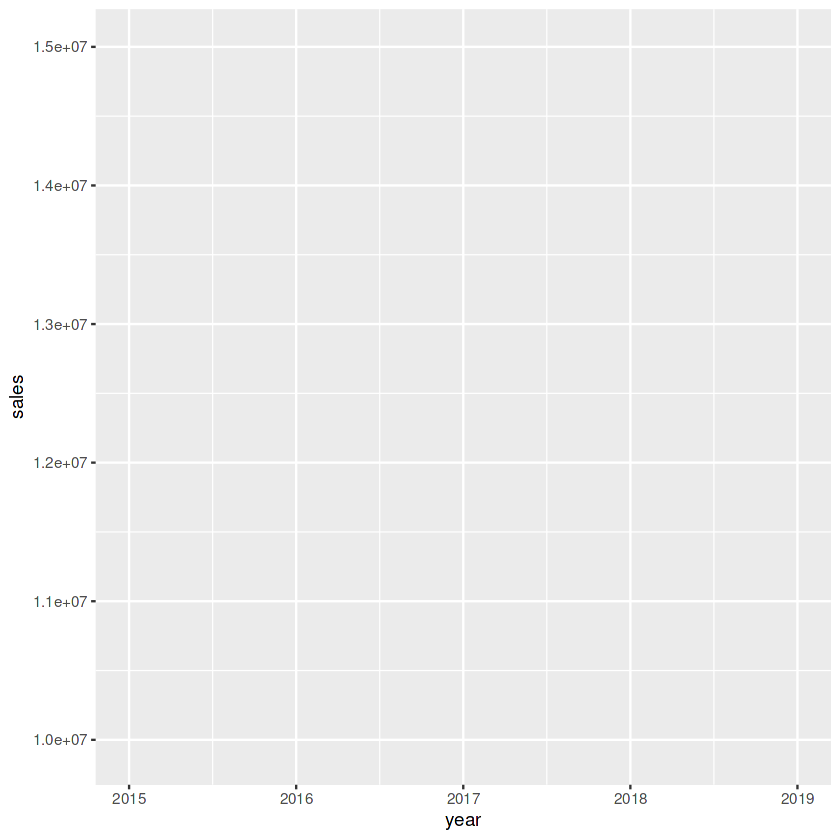

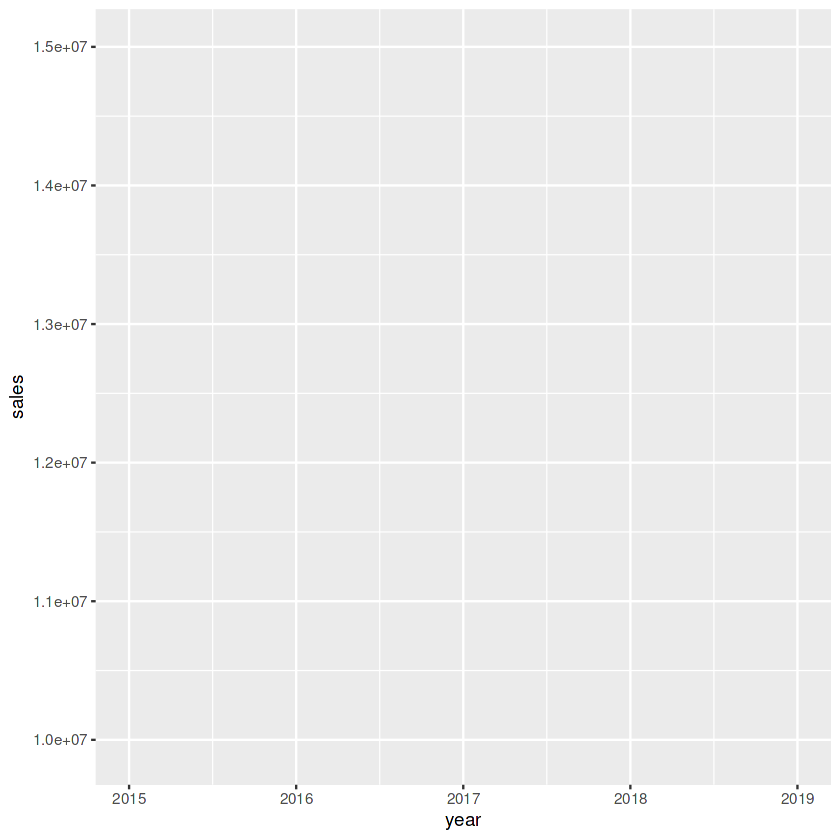

In [112]:
# Step 2: Plot ----
sales_by_year_tbl %>%

      # Canvas
      ggplot(aes(x = year, y = sales, color = sales))
      
# Without piping 
ggplot(data = sales_by_year_tbl, 
       aes(x     = year, 
           y     = sales, 
           color = sales))

* points (geom_point, for scatter plots, dot plots, etc)
* lines (geom_line, for time series, trend lines, etc)
* boxplot (geom_boxplot, for, well, boxplots!)

`geom_smooth()` using formula = 'y ~ x'


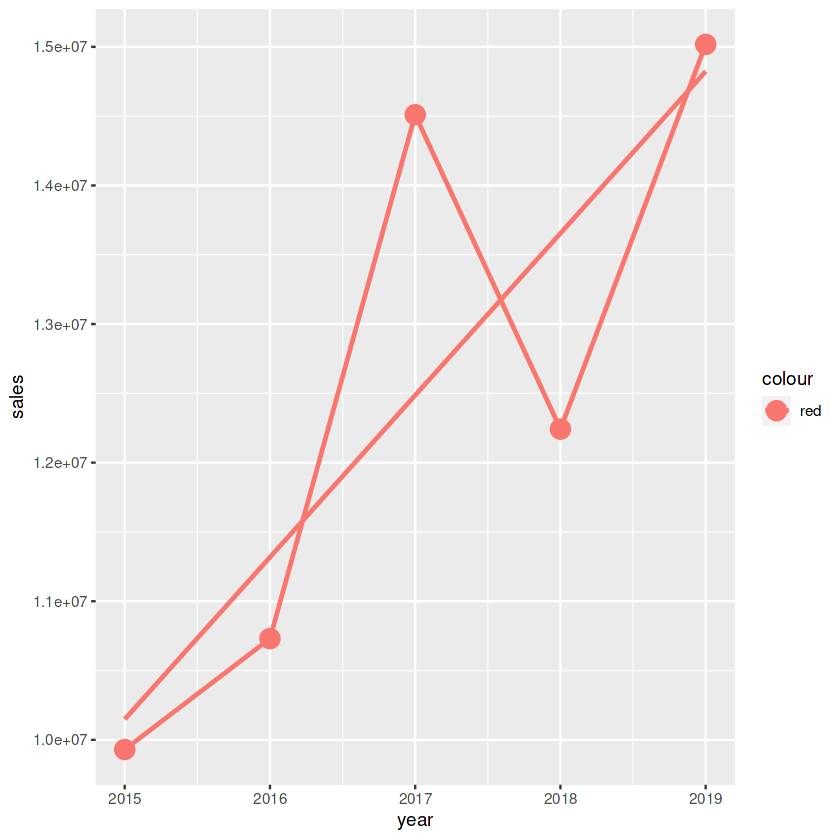

In [113]:
sales_by_year_tbl %>%

  # Canvas
  ggplot(aes(x = year, y = sales, color = "red")) +

  # Geometries 
  geom_line(size = 1) +
  geom_point(size = 5) +
  geom_smooth(method = "lm", se = FALSE)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


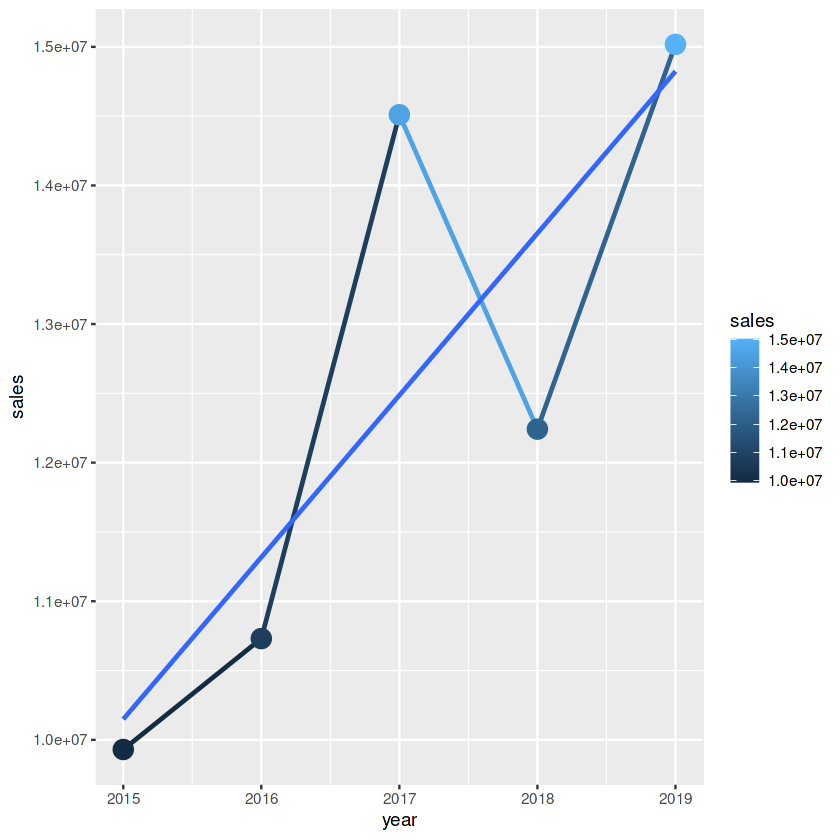

In [114]:
sales_by_year_tbl %>%

  # Canvas
  ggplot(aes(x = year, y = sales, color = sales)) +

  # Geometries 
  geom_line(size = 1) +
  geom_point(size = 5) +
  geom_smooth(method = "lm", se = FALSE)

# Point / Scatter Plots
* Great for Continuous vs Continuous
* Also good for Lollipop Charts (more on this later)
* Goal: Explain relationship between order value and quantity of bikes sold

`geom_smooth()` using formula = 'y ~ x'


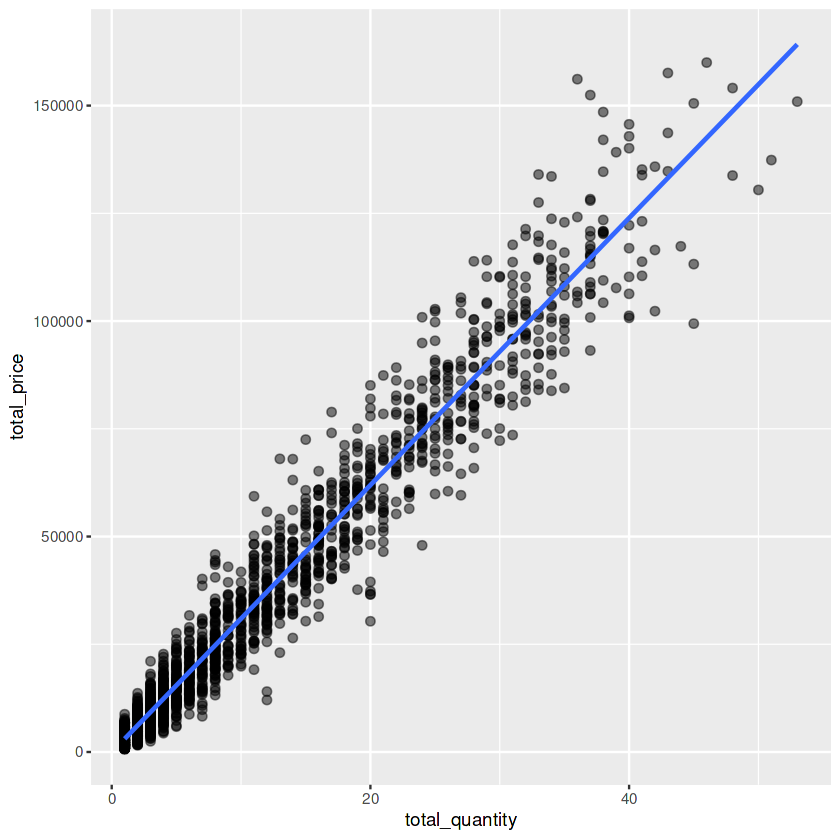

In [115]:
# Data Manipulation
order_value_tbl <- bike_orderlines_tbl %>%
    
    select(order_id, order_line, total_price, quantity) %>%
    
    group_by(order_id) %>%
    summarize(
        total_quantity = sum(quantity),
        total_price    = sum(total_price)
    ) %>%
    ungroup()

# Scatter Plot
order_value_tbl %>%
    
    ggplot(aes(x = total_quantity, y = total_price)) +
    
    geom_point(alpha = 0.5, size = 2) +
    geom_smooth(method = "lm", se = FALSE)

# Line Plots
* Great for time series
* Goal: Describe revenue by month, expose cyclic nature

`geom_smooth()` using formula = 'y ~ x'


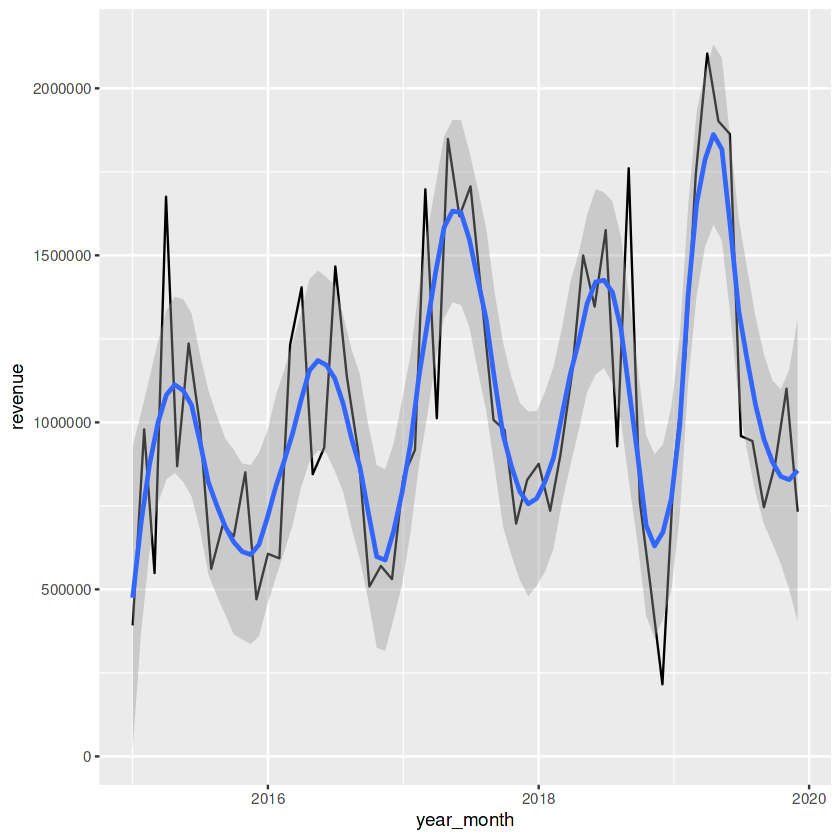

In [116]:
# Data Manipulation
revenue_by_month_tbl <- bike_orderlines_tbl %>%
    
    select(order_date, total_price) %>%
    
    mutate(year_month = floor_date(order_date, "months") %>% ymd()) %>%
    
    group_by(year_month) %>%
    summarize(revenue = sum(total_price)) %>%
    ungroup()

# Line Plot
revenue_by_month_tbl %>%
    
    ggplot(aes(year_month, revenue)) +
    
    geom_line(size = 0.5, linetype = 1) +
    geom_smooth(method = "loess", span = 0.2)

# Bar / Column Plots
* Great for categories
* Goal: Sales by Descriptive Category

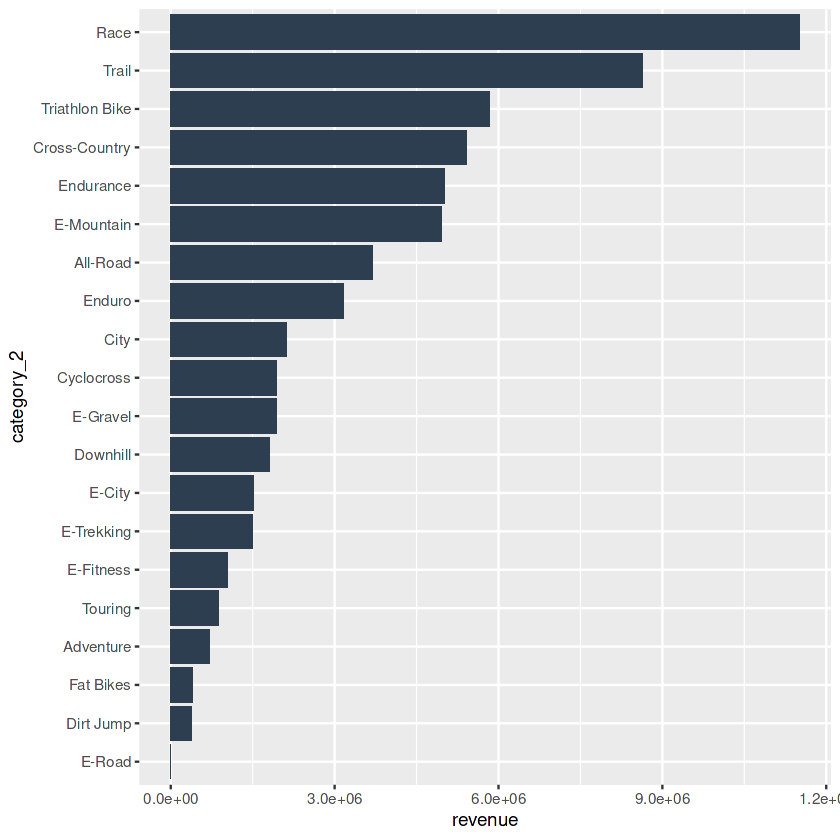

In [117]:
# Data Manipulation
revenue_by_category_2_tbl <- bike_orderlines_tbl %>%
    
    select(category_2, total_price) %>%
    
    group_by(category_2) %>%
    summarize(revenue = sum(total_price)) %>%
    ungroup()

# Bar Plot
revenue_by_category_2_tbl %>%
    
    mutate(category_2 = category_2 %>% as_factor() %>% fct_reorder(revenue)) %>%
    
    ggplot(aes(category_2, revenue)) +
    
    geom_col(fill = "#2c3e50") + 
    coord_flip()

# Histogram / Density Plots
* Great for inspecting the distribution of a variable
* Goal: Unit price of bicycles

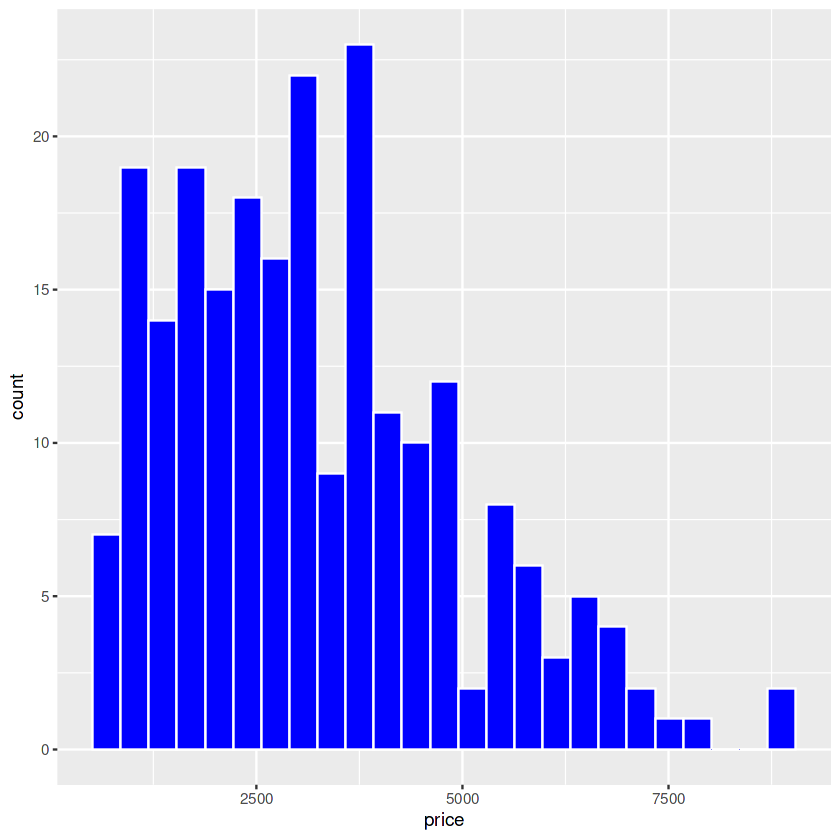

In [118]:
# Histogram

bike_orderlines_tbl %>%
    
    distinct(model, price) %>%
    
    ggplot(aes(price)) +
    
    geom_histogram(bins = 25, fill = "blue", color = "white")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


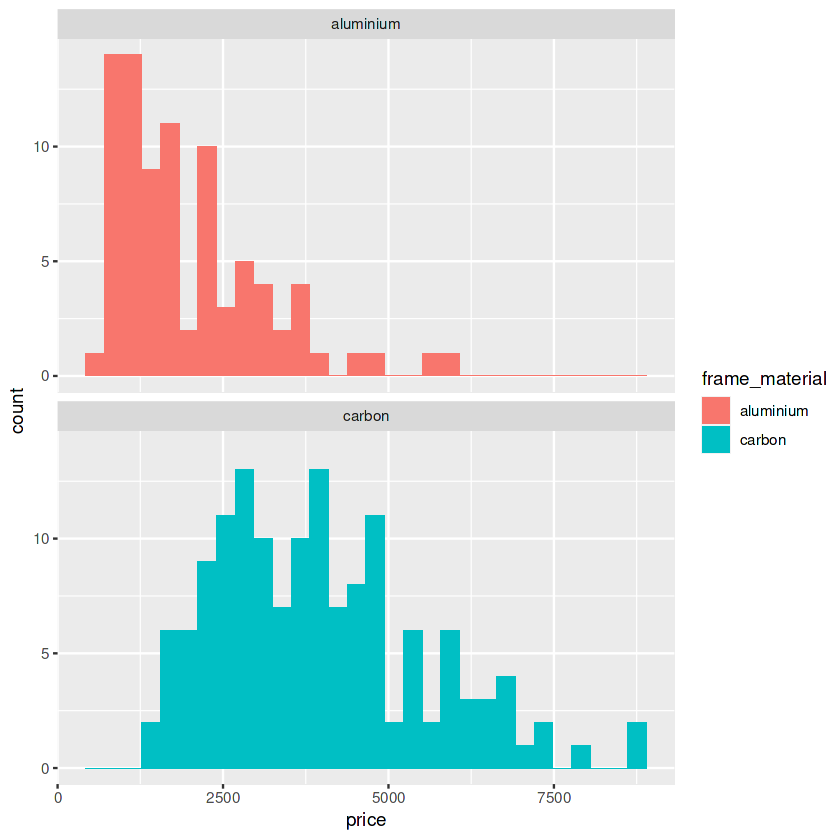

In [119]:
# Histogram
bike_orderlines_tbl %>%
    
    distinct(price, model, frame_material) %>%
    
    ggplot(aes(price, fill = frame_material)) +
    
    geom_histogram() +
    
    facet_wrap(~ frame_material, ncol = 1)

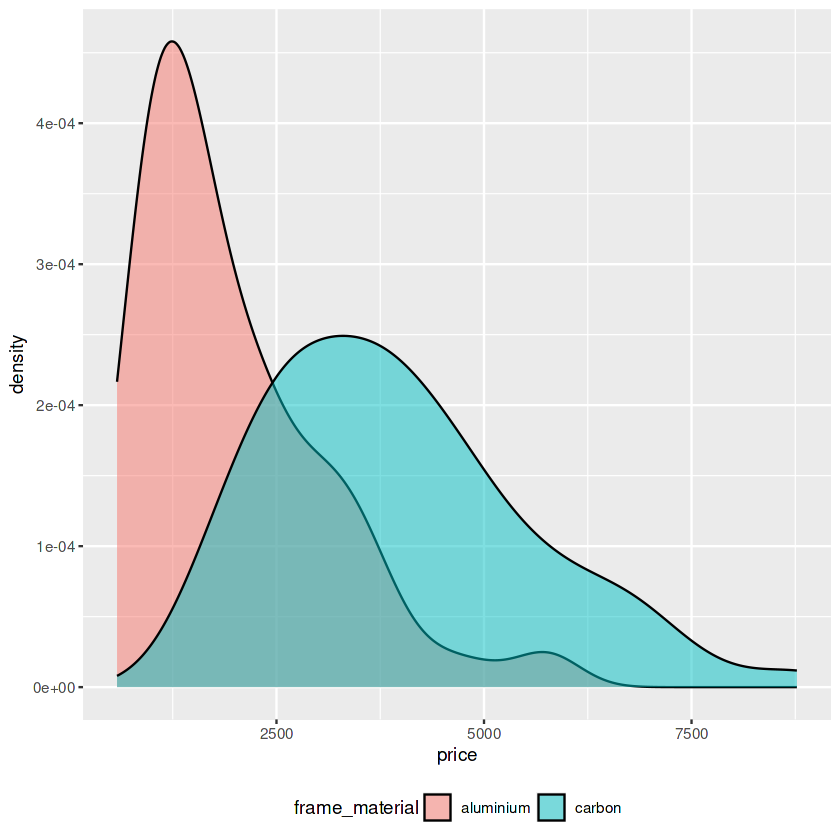

In [120]:
# Density
bike_orderlines_tbl %>%
    
    distinct(price, model, frame_material) %>%
    
    ggplot(aes(price, fill = frame_material)) +
    
    geom_density(alpha = 0.5) +
    # facet_wrap(~ frame_material, ncol = 1) +
  
    theme(legend.position = "bottom")

# Box Plot / Violin Plot
* Great for comparing distributions
* Goal: Unit price of model, segmenting by category 2

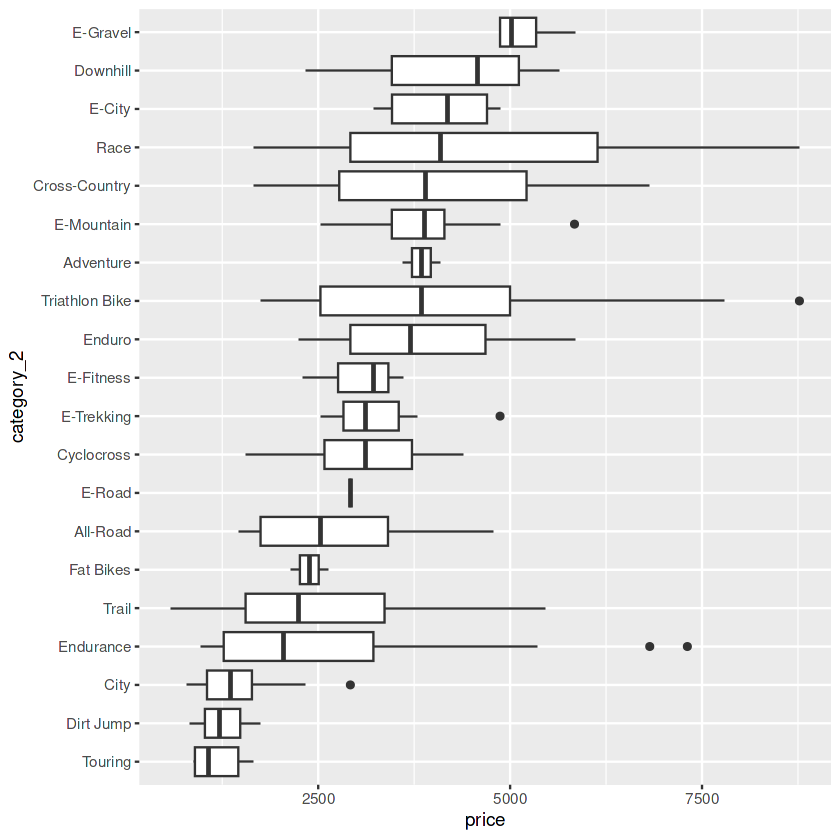

In [121]:
# Data Manipulation
unit_price_by_cat_2_tbl <- bike_orderlines_tbl %>%
    
    select(category_2, model, price) %>%
    distinct() %>%
    
    mutate(category_2 = as_factor(category_2) %>% fct_reorder(price))

# Box Plot
unit_price_by_cat_2_tbl %>%
    
    ggplot(aes(category_2, price)) +
    
    geom_boxplot() +
    coord_flip()

Warning message:
“Groups with fewer than two data points have been dropped.”


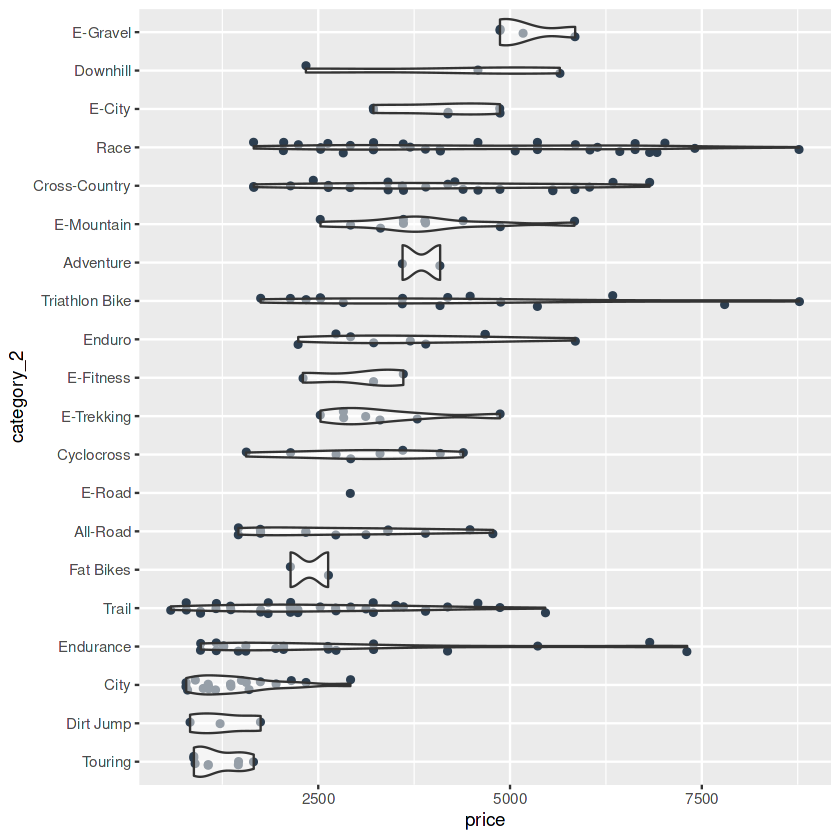

In [122]:
# Violin Plot & Jitter Plot

unit_price_by_cat_2_tbl %>%
    
    ggplot(aes(category_2, price)) +
    
    geom_jitter(width = 0.15, color = "#2c3e50") +
    geom_violin(alpha = 0.5) +
    
    coord_flip()

# Text & Labels
* Goal: Exposing sales over time, highlighting outlier

`geom_smooth()` using formula = 'y ~ x'


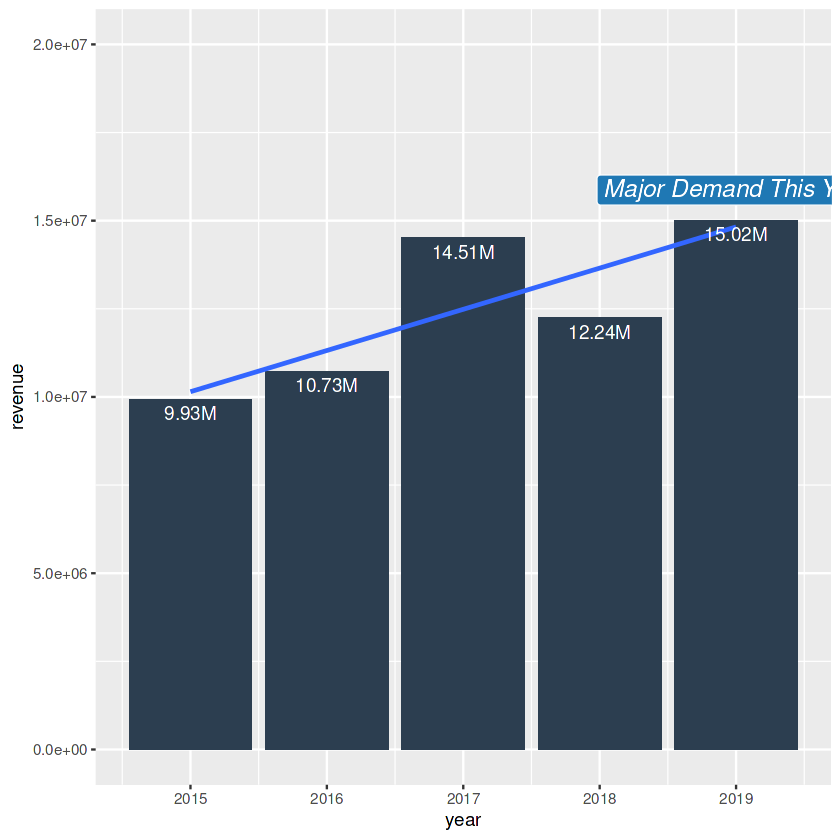

In [123]:
# Data Manipulation

revenue_by_year_tbl <- bike_orderlines_tbl %>%
    
    select(order_date, total_price) %>%
    
    mutate(year = year(order_date)) %>%
    
    group_by(year) %>%
    summarize(revenue = sum(total_price)) %>%
    ungroup()

# Adding text to bar chart
# Filtering labels to highlight a point

revenue_by_year_tbl %>%
    
    ggplot(aes(year, revenue)) +
    
    geom_col(fill = "#2c3e50") +
    geom_smooth(method = "lm", se = FALSE) +
    
    geom_text(aes(label =  scales::dollar(revenue, 
                                          scale  = 1e-6, 
                                          prefix = "",
                                          suffix = "M")), 
              vjust = 1.5, color = "white") +
    
    geom_label(label =  "Major Demand This Year",
               vjust = -0.5, 
               size  = 5,
               fill  = "#1f78b4",
               color = "white",
               fontface = "italic",
               data = revenue_by_year_tbl %>%
                   filter(year %in% c(2019))) + 
    
    expand_limits(y = 2e7)

# Formatting

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


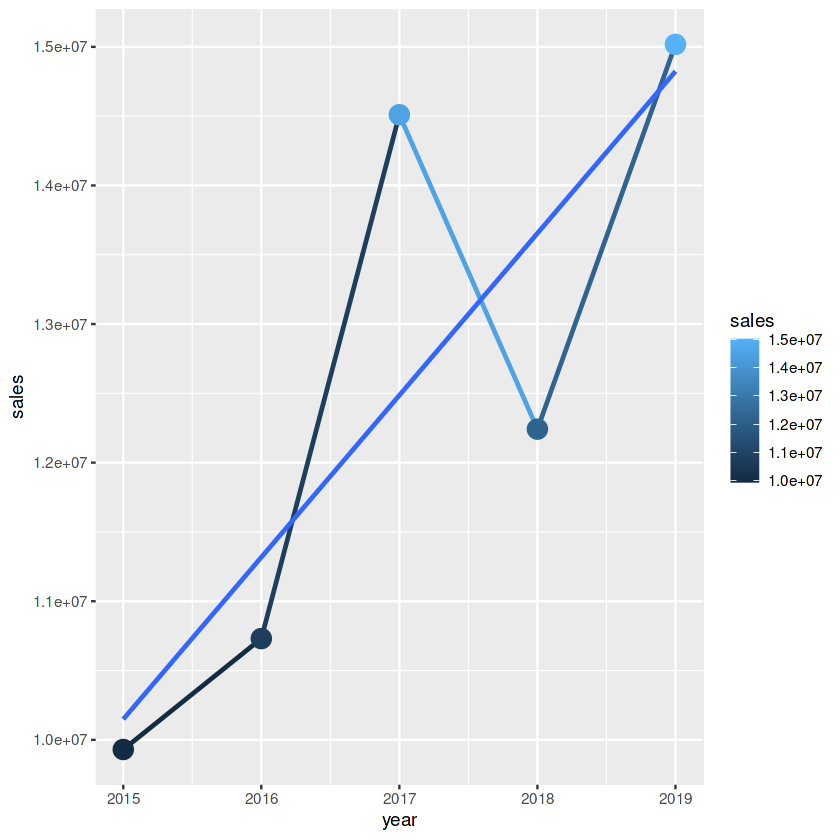

In [124]:
sales_by_year_tbl %>%

  # Canvas
  ggplot(aes(x = year, y = sales, color = sales)) +

  # Geometries 
  geom_line(size = 1) +
  geom_point(size = 5) +
  geom_smooth(method = "lm", se = FALSE) +

  # same as above, with explicit scales
  scale_x_continuous() +
  scale_y_continuous() +
  scale_colour_continuous()

`geom_smooth()` using formula = 'y ~ x'


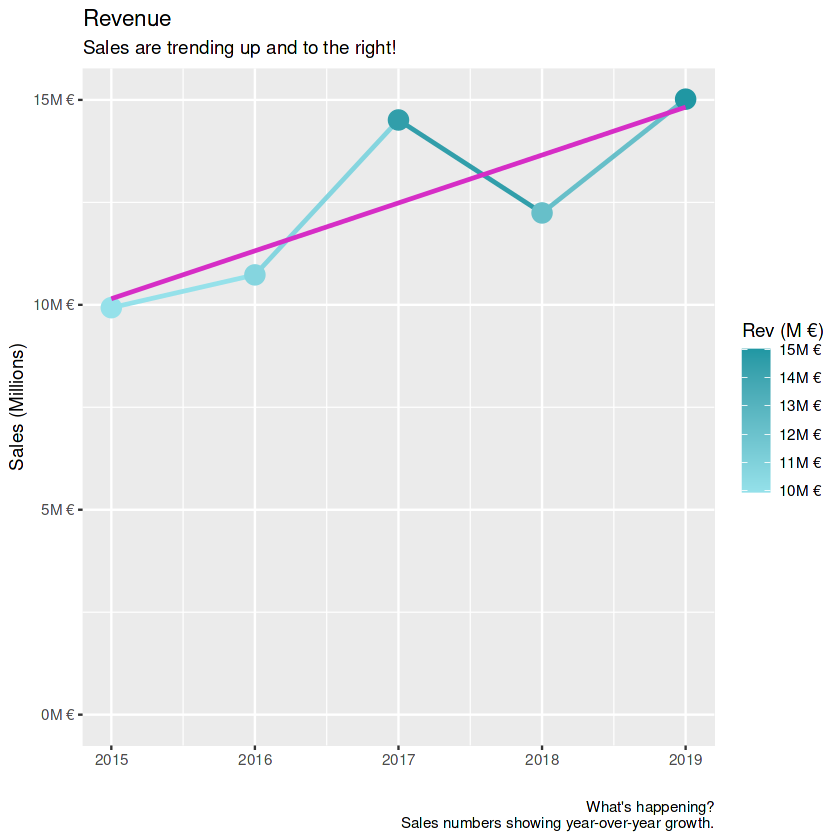

In [125]:
sales_by_year_tbl %>%

  # Canvas
  ggplot(aes(x = year, y = sales, color = sales)) +

  # Geometries 
  geom_line(size = 1) +
  geom_point(size = 5) +
  geom_smooth(method = "lm", se = FALSE, color = "#d62dc6") +

  # Formatting
  expand_limits(y = 0) +
  # You can also type "red", "black" etc. for the colors
  scale_color_continuous(low    = "#95E1EA", high = "#2097A3", 
                         labels = scales::dollar_format(scale  = 1/1e6, 
                                                        prefix = "", 
                                                        suffix = "M €")) +
  scale_y_continuous(labels = scales::dollar_format(scale  = 1/1e6, 
                                                    prefix = "", 
                                                    suffix = "M €")) +
labs(
    title = "Revenue",
    subtitle = "Sales are trending up and to the right!",
    x = "",
    y = "Sales (Millions)",
    color = "Rev (M €)",
    caption = "What's happening?\nSales numbers showing year-over-year growth."
  )

# Themes

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


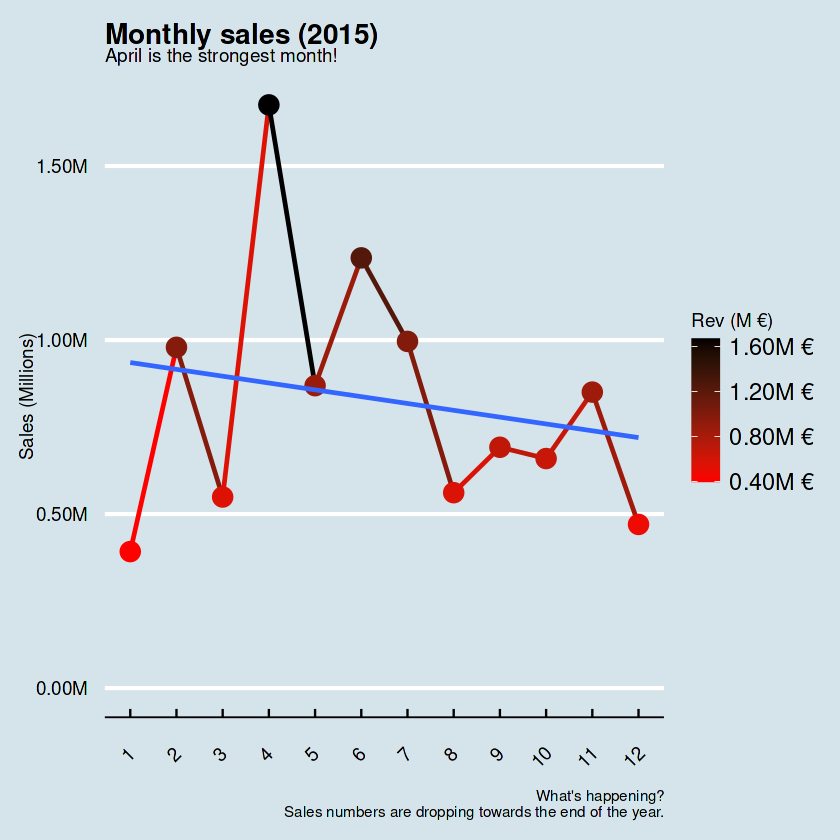

In [126]:
library(ggthemes)
## DATA PREPARATION
sales_by_month_2015 <- bike_orderlines_tbl %>%

  # Selecting columns to focus on and adding a month column
  select(order_date, total_price) %>%
  mutate(year  = year(order_date)) %>% 
  mutate(month = month(order_date)) %>%

  filter(year == "2015") %>%

  # Grouping by month, and summarizing sales
  group_by(month) %>%
  summarize(sales = sum(total_price)) %>%
  ungroup() %>%

  # $ Format Text
  mutate(sales_text = scales::dollar(sales, big.mark = ".",
                                     decimal.mark    = ",",
                                     prefix          = "",  
                                     suffix          = " €"))

## PLOTTING
  # Canvas
  sales_by_month_2015 %>% 
      ggplot(aes(x = month, y = sales, color = sales)) +

  # Geometries 
  geom_line(size = 1) +
  geom_point(size = 5) +
  geom_smooth(method = "lm", se = FALSE) +

  # Formatting
  expand_limits(y = 0) +
  scale_color_continuous(low = "red", high = "black",
                         labels = scales::dollar_format(scale = 1/1e6, 
                                                        prefix = "", 
                                                        suffix = "M €")) +
  scale_x_continuous(breaks = sales_by_month_2015$month, 
                     #labels = month(sales_by_month_2015$month, label = T)) +
                         labels = scales::date_format("%b")) +
  scale_y_continuous(labels = scales::dollar_format(scale = 1/1e6, 
                                                    prefix = "", 
                                                    suffix = "M")) +
  labs(
    title = "Monthly sales (2015)",
    subtitle = "April is the strongest month!",
    x = "",
    y = "Sales (Millions)",
    color = "Rev (M €)",
    caption = "What's happening?\nSales numbers are dropping towards the end of the year."
  )  +  
  theme_economist() +
  theme(legend.position  = "right", 
        legend.direction = "vertical",
        axis.text.x = element_text(angle = 45))

# Example of formatting

In [127]:
# Data Manipulation

sales_by_year_category_1_tbl <- bike_orderlines_tbl %>%
    select(order_date, category_1, total_price) %>%

    mutate(order_date = ymd(order_date)) %>%
    mutate(year = year(order_date)) %>%

    group_by(category_1, year) %>%
    summarize(revenue = sum(total_price)) %>%
    ungroup() %>%

    # Convert character vectors to factors
    # Arrange by year and revenue
    mutate(category_1 = fct_reorder2(category_1, year, revenue))

sales_by_year_category_1_tbl

# Uncover the factor levels (just for demonstration)
# sorted by years and the highest revenues
sales_by_year_category_1_tbl %>%
    mutate(category_1_num = as.numeric(category_1)) %>%
    arrange(category_1_num)

`summarise()` has grouped output by 'category_1'. You can override using the
`.groups` argument.


category_1    year revenue
1  E-Bikes       2015 1599048
2  E-Bikes       2016 1916469
3  E-Bikes       2017 2617352
4  E-Bikes       2018 2151550
5  E-Bikes       2019 2667921
6  Gravel        2015  663025
7  Gravel        2016  768794
8  Gravel        2017 1006839
9  Gravel        2018  792234
10 Gravel        2019 1169038
11 Hybrid / City 2015  502512
12 Hybrid / City 2016  512346
13 Hybrid / City 2017  784491
14 Hybrid / City 2018  576805
15 Hybrid / City 2019  617064
16 Mountain      2015 3254289
17 Mountain      2016 3288733
18 Mountain      2017 4482867
19 Mountain      2018 4090277
20 Mountain      2019 4674327
21 Road          2015 3911408
22 Road          2016 4244165
23 Road          2017 5618742
24 Road          2018 4630987
25 Road          2019 5889525

category_1    year revenue category_1_num
1  Road          2015 3911408 1             
2  Road          2016 4244165 1             
3  Road          2017 5618742 1             
4  Road          2018 4630987 1             
5  Road          2019 5889525 1             
6  Mountain      2015 3254289 2             
7  Mountain      2016 3288733 2             
8  Mountain      2017 4482867 2             
9  Mountain      2018 4090277 2             
10 Mountain      2019 4674327 2             
11 E-Bikes       2015 1599048 3             
12 E-Bikes       2016 1916469 3             
13 E-Bikes       2017 2617352 3             
14 E-Bikes       2018 2151550 3             
15 E-Bikes       2019 2667921 3             
16 Gravel        2015  663025 4             
17 Gravel        2016  768794 4             
18 Gravel        2017 1006839 4             
19 Gravel        2018  792234 4             
20 Gravel        2019 1169038 4             
21 Hybrid / City 2015  502512 5             
22 Hybrid / City 2016  512346 5             
23 Hybrid / City 2017  784491 5             
24 Hybrid / City 2018  576805 5             
25 Hybrid / City 2019  617064 5

* 1.1 Color Conversion

[1] "white"                "aliceblue"            "antiquewhite"        
  [4] "antiquewhite1"        "antiquewhite2"        "antiquewhite3"       
  [7] "antiquewhite4"        "aquamarine"           "aquamarine1"         
 [10] "aquamarine2"          "aquamarine3"          "aquamarine4"         
 [13] "azure"                "azure1"               "azure2"              
 [16] "azure3"               "azure4"               "beige"               
 [19] "bisque"               "bisque1"              "bisque2"             
 [22] "bisque3"              "bisque4"              "black"               
 [25] "blanchedalmond"       "blue"                 "blue1"               
 [28] "blue2"                "blue3"                "blue4"               
 [31] "blueviolet"           "brown"                "brown1"              
 [34] "brown2"               "brown3"               "brown4"              
 [37] "burlywood"            "burlywood1"           "burlywood2"          
 [40] "burlywood3"           "burlywood4"           "cadetblue"           
 [43] "cadetblue1"           "cadetblue2"           "cadetblue3"          
 [46] "cadetblue4"           "chartreuse"           "chartreuse1"         
 [49] "chartreuse2"          "chartreuse3"          "chartreuse4"         
 [52] "chocolate"            "chocolate1"           "chocolate2"          
 [55] "chocolate3"           "chocolate4"           "coral"               
 [58] "coral1"               "coral2"               "coral3"              
 [61] "coral4"               "cornflowerblue"       "cornsilk"            
 [64] "cornsilk1"            "cornsilk2"            "cornsilk3"           
 [67] "cornsilk4"            "cyan"                 "cyan1"               
 [70] "cyan2"                "cyan3"                "cyan4"               
 [73] "darkblue"             "darkcyan"             "darkgoldenrod"       
 [76] "darkgoldenrod1"       "darkgoldenrod2"       "darkgoldenrod3"      
 [79] "darkgoldenrod4"       "darkgray"             "darkgreen"           
 [82] "darkgrey"             "darkkhaki"            "darkmagenta"         
 [85] "darkolivegreen"       "darkolivegreen1"      "darkolivegreen2"     
 [88] "darkolivegreen3"      "darkolivegreen4"      "darkorange"          
 [91] "darkorange1"          "darkorange2"          "darkorange3"         
 [94] "darkorange4"          "darkorchid"           "darkorchid1"         
 [97] "darkorchid2"          "darkorchid3"          "darkorchid4"         
[100] "darkred"              "darksalmon"           "darkseagreen"        
[103] "darkseagreen1"        "darkseagreen2"        "darkseagreen3"       
[106] "darkseagreen4"        "darkslateblue"        "darkslategray"       
[109] "darkslategray1"       "darkslategray2"       "darkslategray3"      
[112] "darkslategray4"       "darkslategrey"        "darkturquoise"       
[115] "darkviolet"           "deeppink"             "deeppink1"           
[118] "deeppink2"            "deeppink3"            "deeppink4"           
[121] "deepskyblue"          "deepskyblue1"         "deepskyblue2"        
[124] "deepskyblue3"         "deepskyblue4"         "dimgray"             
[127] "dimgrey"              "dodgerblue"           "dodgerblue1"         
[130] "dodgerblue2"          "dodgerblue3"          "dodgerblue4"         
[133] "firebrick"            "firebrick1"           "firebrick2"          
[136] "firebrick3"           "firebrick4"           "floralwhite"         
[139] "forestgreen"          "gainsboro"            "ghostwhite"          
[142] "gold"                 "gold1"                "gold2"               
[145] "gold3"                "gold4"                "goldenrod"           
[148] "goldenrod1"           "goldenrod2"           "goldenrod3"          
[151] "goldenrod4"           "gray"                 "gray0"               
[154] "gray1"                "gray2"                "gray3"               
[157] "gray4"                "gray5"                "gray6"               
[160] "gray7"              

[,1]
red   106 
green  90 
blue  205

[,1]
red   44  
green 62  
blue  80

[1] "#2C3E50"

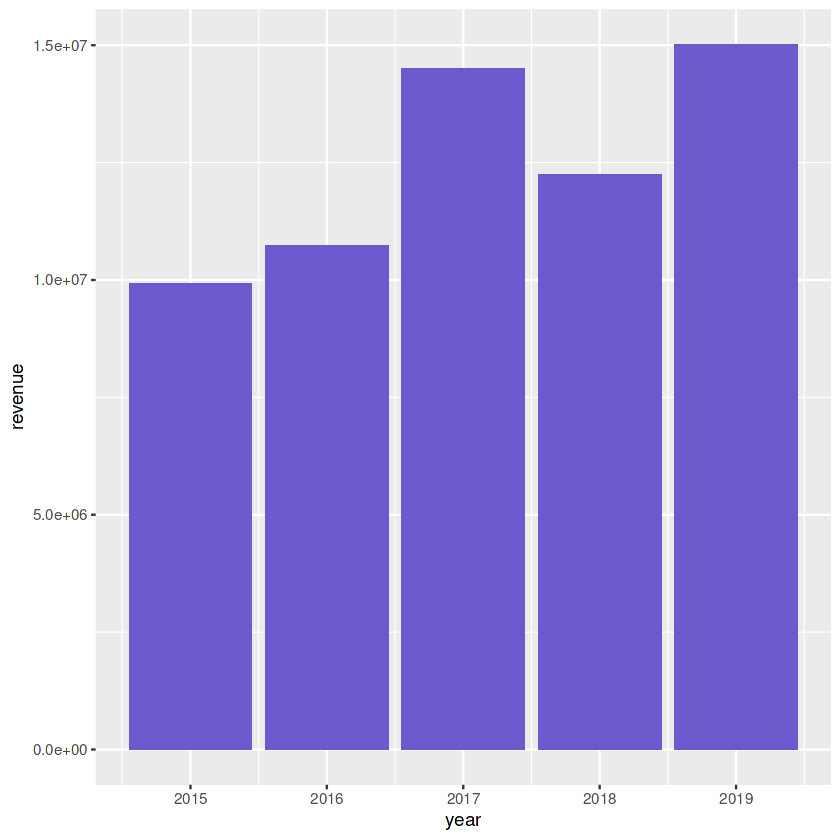

In [128]:
# Named Colors. This returns a long list of colors that can be used by name
colors()

# Example
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue)) +

    geom_col(fill = "slateblue")

# To RGB
col2rgb("slateblue")

col2rgb("#2C3E50")

# To HEX (this function should be provided to a geom)
rgb(44, 62, 80, maxColorValue = 255)

* 1.2 Color Palettes: Colors that are typically work well together.

maxcolors category colorblind
BrBG     11        div       TRUE     
PiYG     11        div       TRUE     
PRGn     11        div       TRUE     
PuOr     11        div       TRUE     
RdBu     11        div       TRUE     
RdGy     11        div      FALSE     
RdYlBu   11        div       TRUE     
RdYlGn   11        div      FALSE     
Spectral 11        div      FALSE     
Accent    8        qual     FALSE     
Dark2     8        qual      TRUE     
Paired   12        qual      TRUE     
Pastel1   9        qual     FALSE     
Pastel2   8        qual     FALSE     
Set1      9        qual     FALSE     
Set2      8        qual      TRUE     
Set3     12        qual     FALSE     
Blues     9        seq       TRUE     
BuGn      9        seq       TRUE     
BuPu      9        seq       TRUE     
GnBu      9        seq       TRUE     
Greens    9        seq       TRUE     
Greys     9        seq       TRUE     
Oranges   9        seq       TRUE     
OrRd      9        seq       TRUE     
PuBu      9        seq       TRUE     
PuBuGn    9        seq       TRUE     
PuRd      9        seq       TRUE     
Purples   9        seq       TRUE     
RdPu      9        seq       TRUE     
Reds      9        seq       TRUE     
YlGn      9        seq       TRUE     
YlGnBu    9        seq       TRUE     
YlOrBr    9        seq       TRUE     
YlOrRd    9        seq       TRUE

[1] "#F7FBFF"

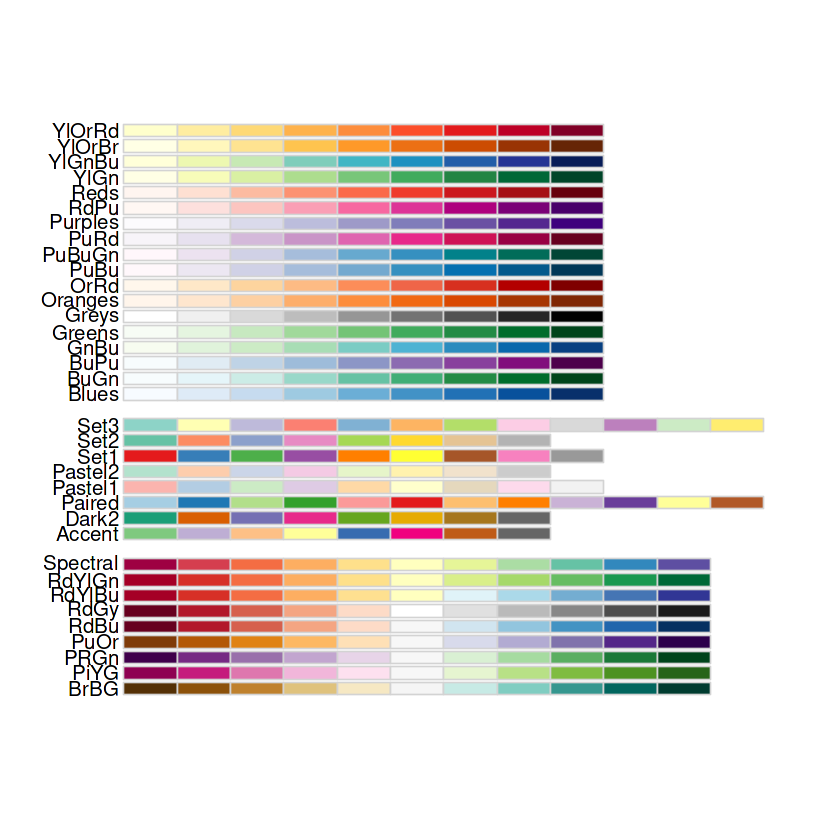

[1] "#440154FF" "#481568FF" "#482677FF" "#453781FF" "#3F4788FF" "#39558CFF"
 [7] "#32648EFF" "#2D718EFF" "#287D8EFF" "#238A8DFF" "#1F968BFF" "#20A386FF"
[13] "#29AF7FFF" "#3CBC75FF" "#56C667FF" "#74D055FF" "#94D840FF" "#B8DE29FF"
[19] "#DCE318FF" "#FDE725FF"

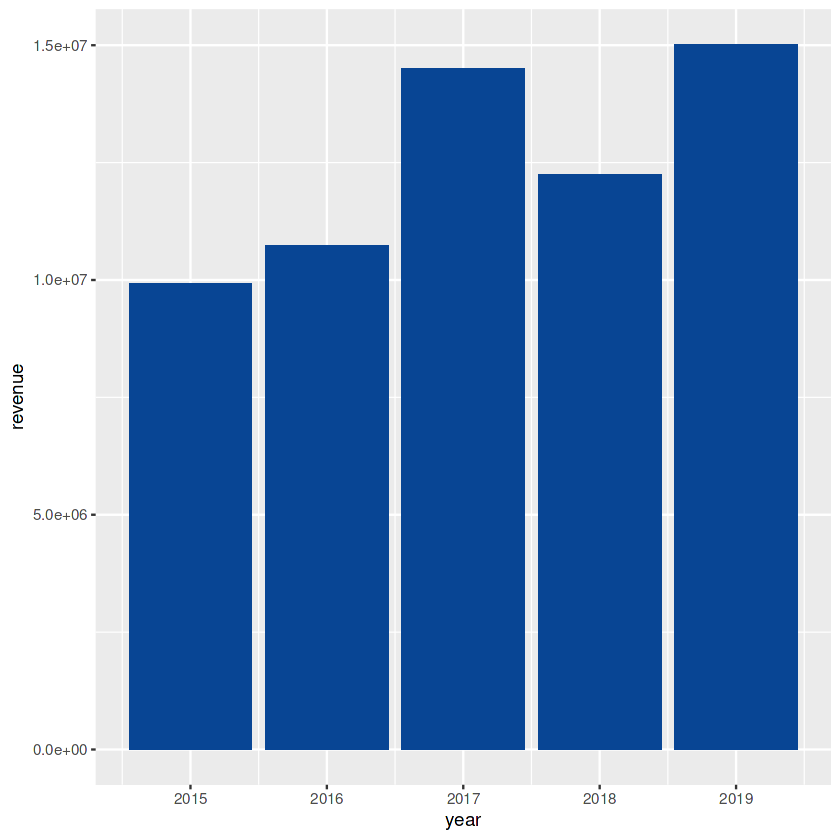

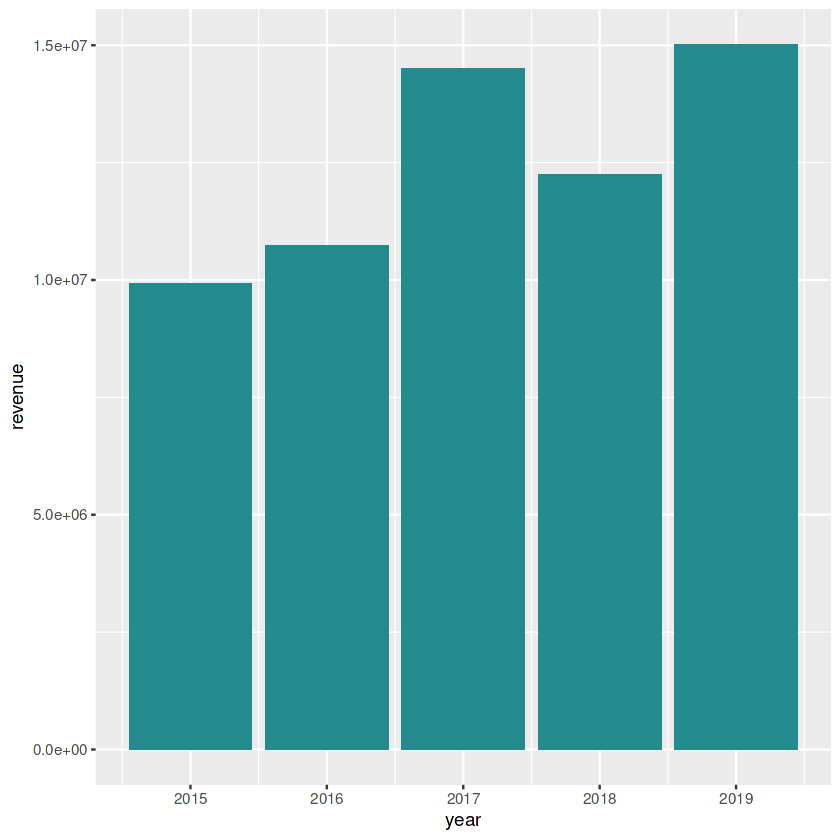

In [129]:
### Brewer. Comes with basic R.
#Primarly for discrete data.

# We can use those palletes by just calling their names (e.g. "Blues")
# Display the colors
RColorBrewer::display.brewer.all() 
# Get information
RColorBrewer::brewer.pal.info
# Get the HEX codes
RColorBrewer::brewer.pal(n = 8, name = "Blues")[1]

# Example
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue)) +

    geom_col(fill = RColorBrewer::brewer.pal(n = 8, name = "Blues")[8])


### Viridis
viridisLite::viridis(n = 20)
# The last two characters indicate the transparency (e.g. FF makes it 100% transparent)

# Example
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue)) +

    geom_col(fill = viridisLite::viridis(n = 20)[10])

# Aesthetic Mappings
* All possible aestehetics for each geom, can be found in the corresponding help pages (e.g. ?geom_point).

* 2.1 Color: Used with line and points, Outlines of rectangular objects

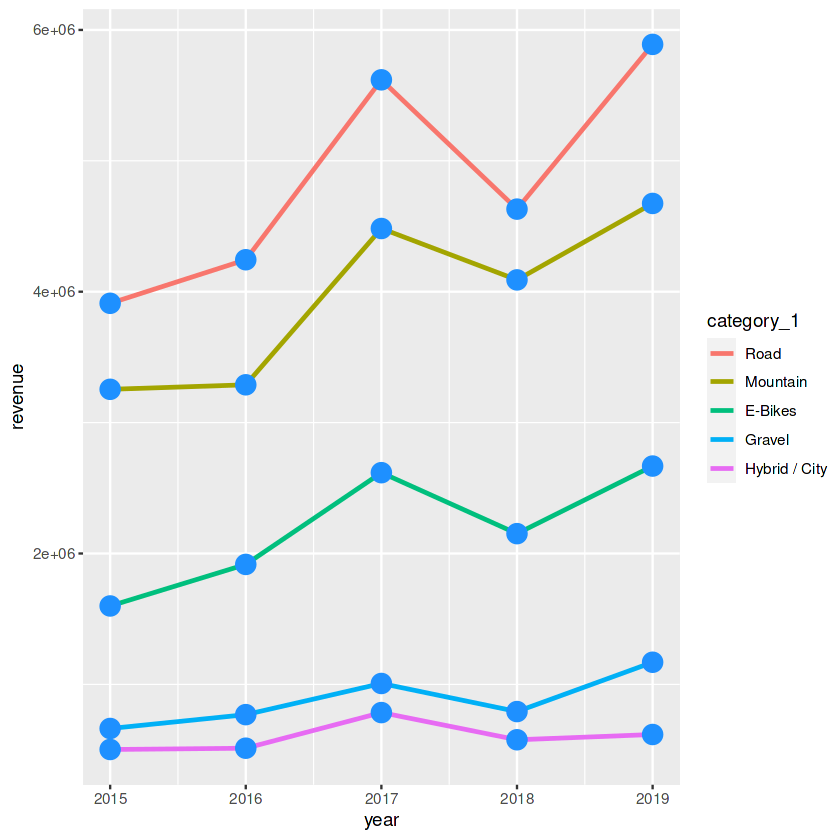

In [130]:
sales_by_year_category_1_tbl %>%

    # Put the aes color mapping here, to apply it to geom_line and geom_point
    ggplot(aes(year, revenue, color = category_1)) +

    # Or you could do it locally in each geom 
    # (aes mapping only necessary if you map it to a column)
    geom_line(size = 1) + # geom_line(aes(color = category_1))
    geom_point(color = "dodgerblue", size = 5)

* 2.2 Fill: Used with fill of rectangular objects (stacked column chart in this case)

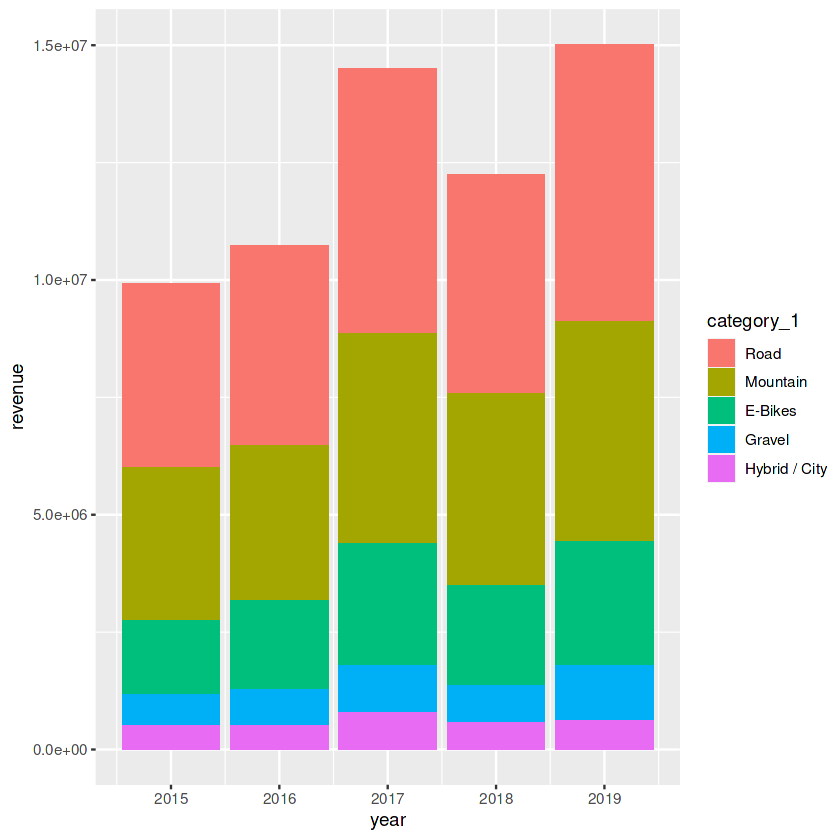

In [131]:
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue)) +
    geom_col(aes(fill = category_1)) 
    # You could use color = ... to color the outlines

* 2.3 Size: Typically used with points

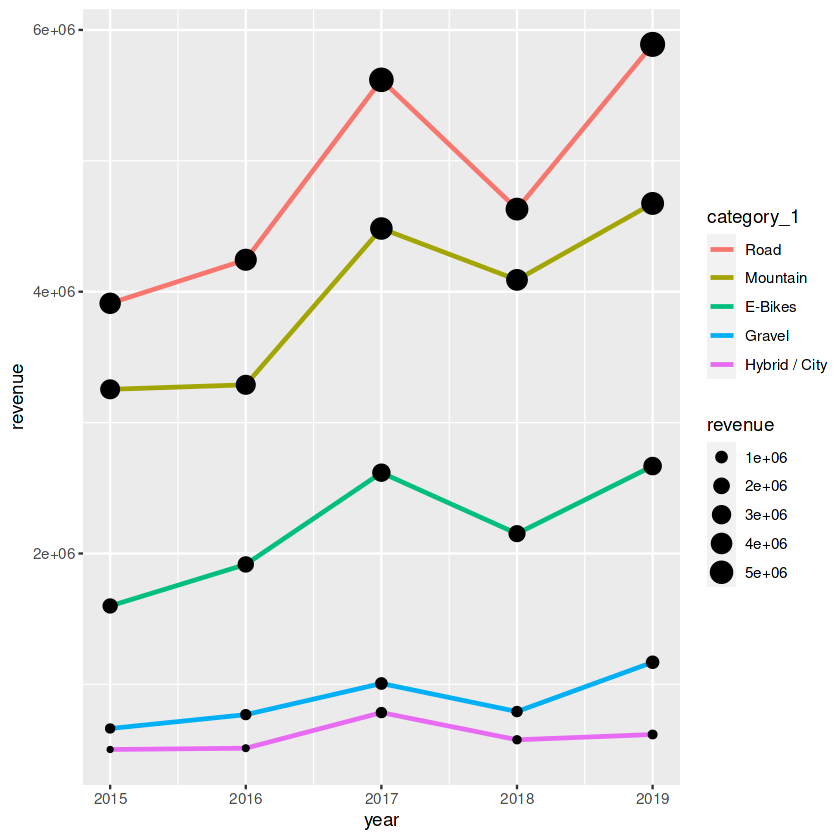

In [132]:
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, size = revenue)) +

    # The local size overrides the global size
    geom_line(aes(color = category_1), size = 1) + 
    geom_point()

# Faceting
* facet_wrap() separates a plot with groups into multiple plots (aka facets)
* Great way to tease out variation by category
* Goal: Sales annual sales by category 1

`geom_smooth()` using formula = 'y ~ x'


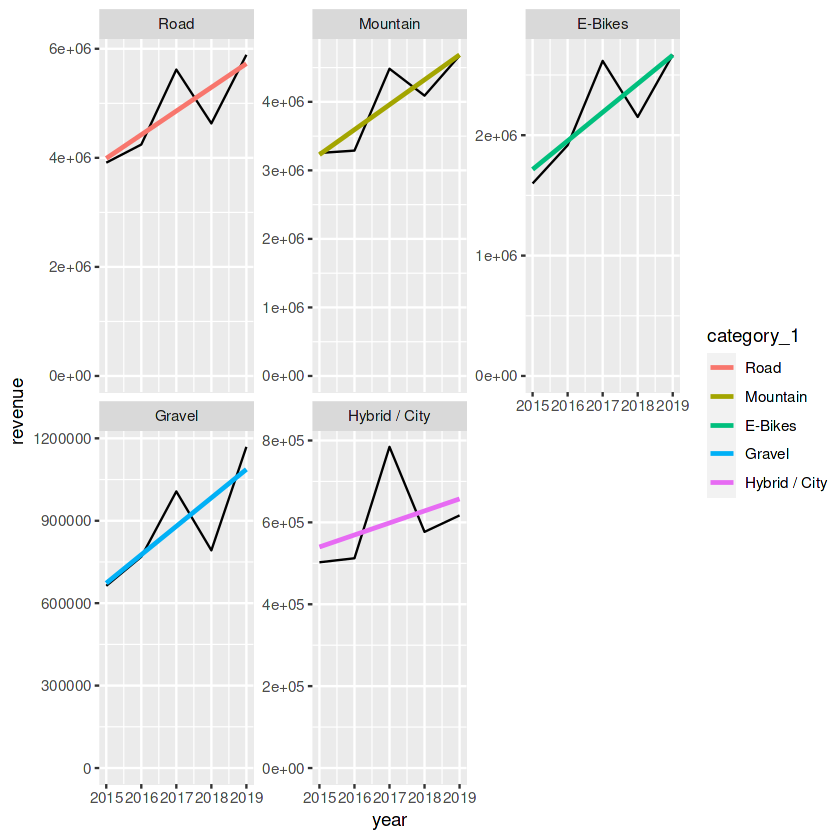

In [133]:
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, color = category_1)) +
    geom_line(color = "black") +
    geom_smooth(method = "lm", se = FALSE) +
    
    # Break out stacked plot
    facet_wrap(~ category_1, ncol = 3, scales = "free_y") +

    expand_limits(y = 0)

# Position Adjustments (Stack & Dodge)
* Using the position argument to plot Stacked Bars & Side-By-Side Bars

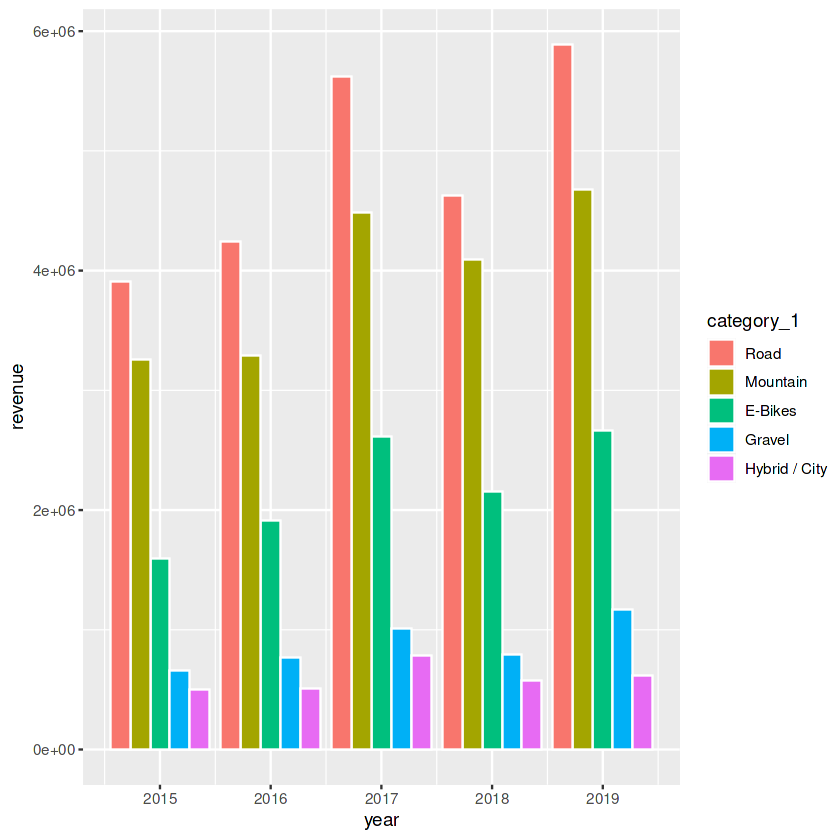

In [134]:
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, fill = category_1)) +
    # geom_col(position = "stack") # default
    # geom_col(position = "dodge")
    geom_col(position = position_dodge(width = 0.9), color = "white")

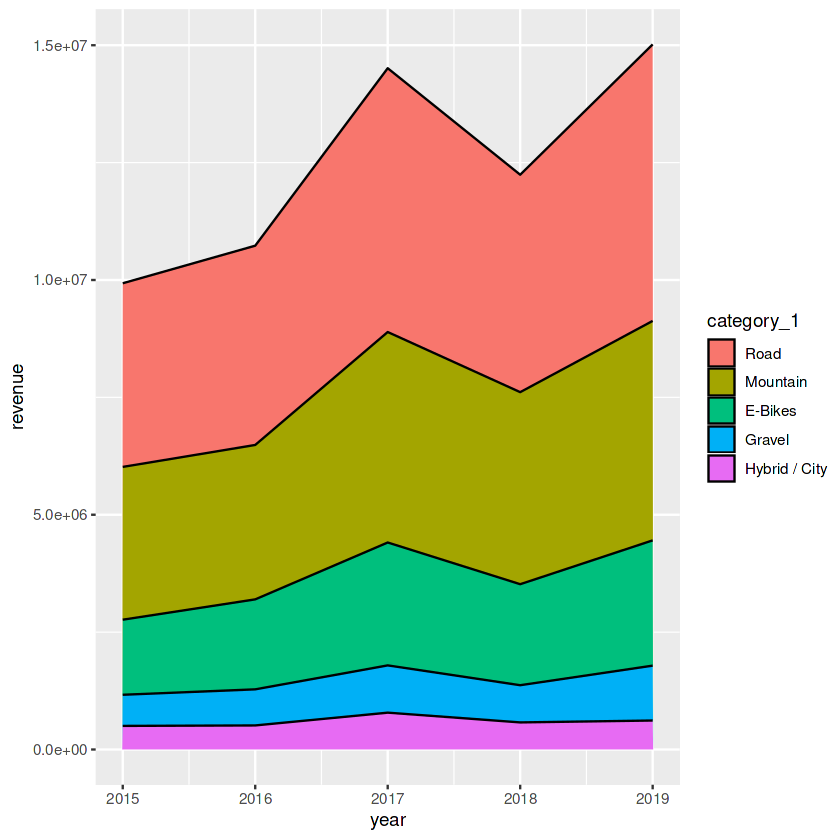

In [135]:
# Stacked Area

sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, fill = category_1)) +
    geom_area(color = "black")

# Scales (Colors, Fills, Axis)
**1 Plot Starting Points**
* Continuous (e.g. Revenue): Changes color via gradient palette
* Categorical (e.g. category_2): Changes color via discrete palette


* Plot 1: Faceted Plot, Color = Continuous Scale

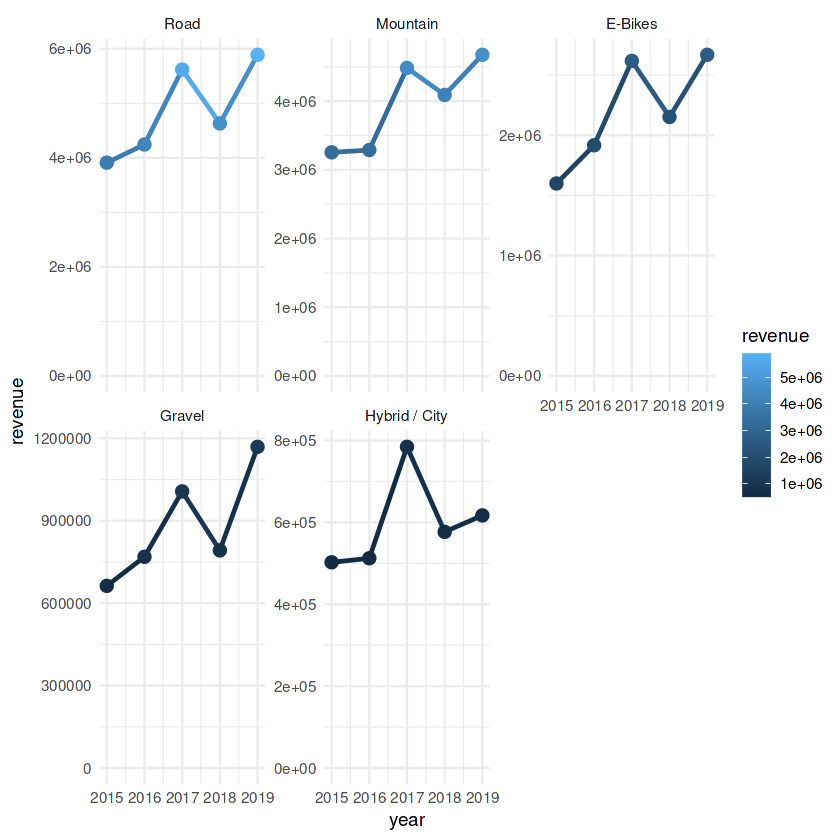

In [136]:
g_facet_continuous <- sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, color = revenue)) +
    geom_line(size = 1) +
    geom_point(size = 3) +

    facet_wrap(~ category_1, scales = "free_y") +
    expand_limits(y = 0) +

    theme_minimal()

g_facet_continuous

* Plot 2: Faceted Plot, Color = Discrete Scale

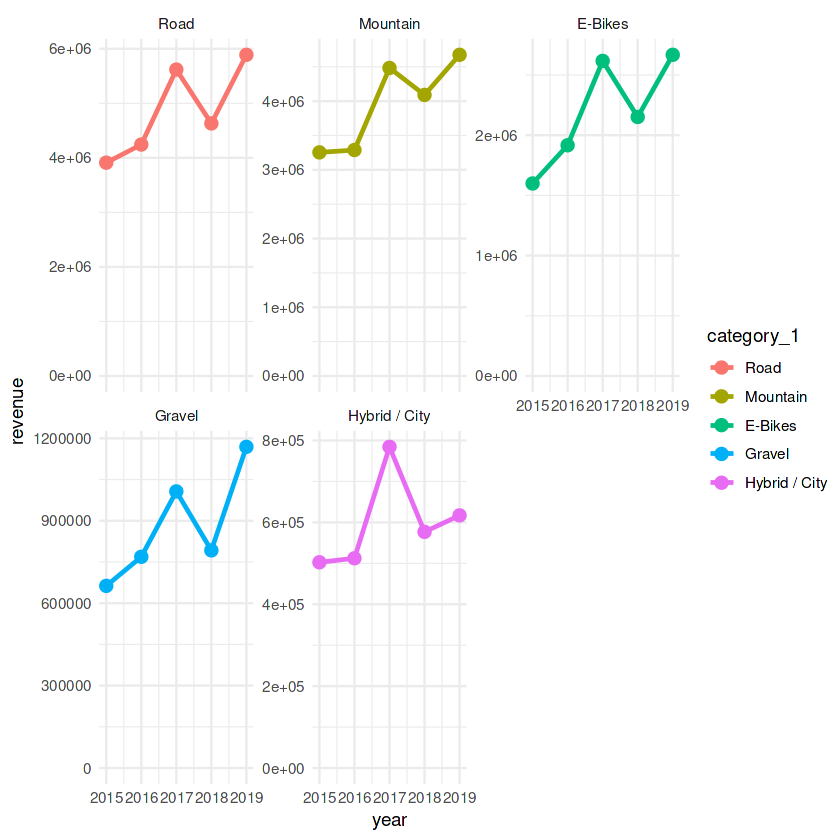

In [137]:
g_facet_discrete <- sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, color = category_1)) +
    geom_line(size = 1) +
    geom_point(size = 3) +

    facet_wrap(~ category_1, scales = "free_y") +
    expand_limits(y = 0) +

    theme_minimal()

g_facet_discrete

* Plot 3: Stacked Area Plot

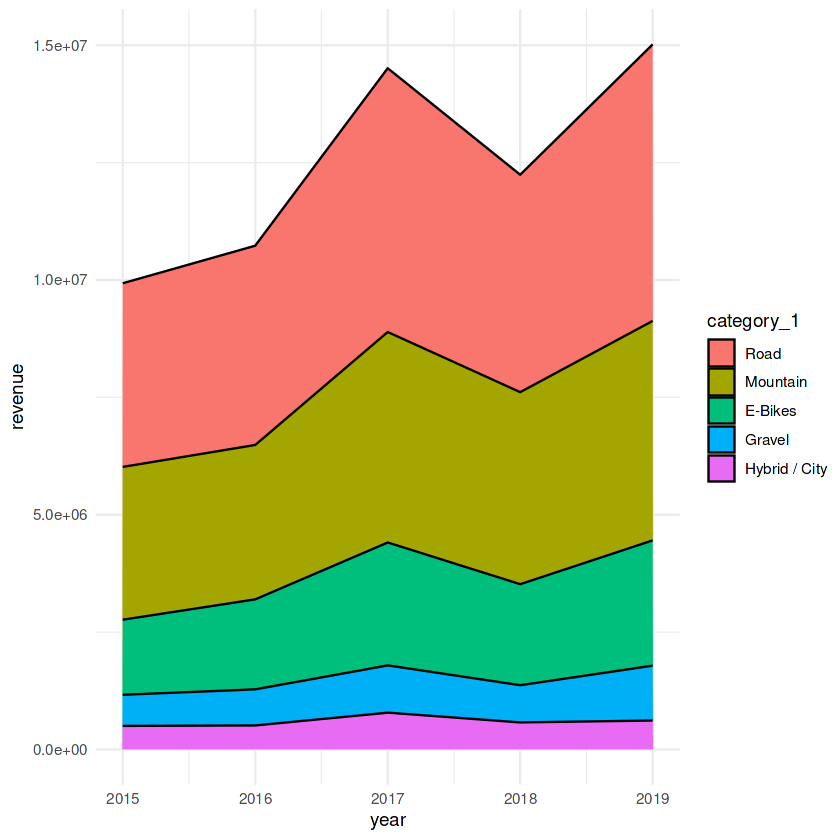

In [138]:
g_area_discrete <- sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, fill = category_1)) +
    geom_area(color = "black") +

    theme_minimal()

g_area_discrete

# 2 Scale Colors & Fills

* Awesome way to show variation by groups (discrete) and by values (continuous).


* 2.1 Color by Revenue (Continuous Scale)

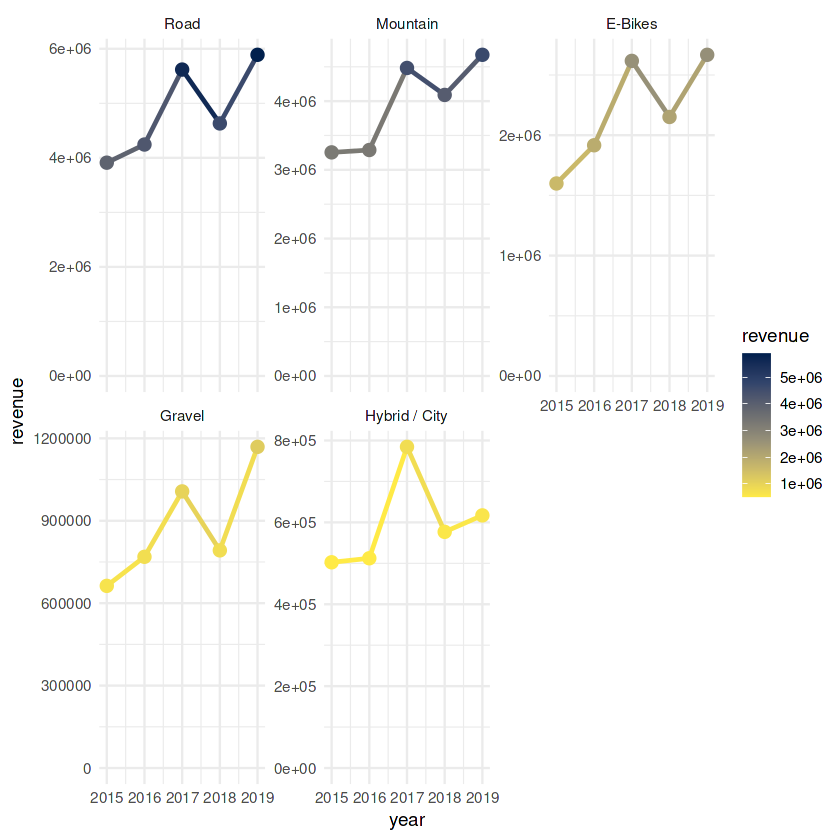

In [139]:
g_facet_continuous +

    # scale_color_continuous(
    #     low   = "black",
    #     high  = "cornflowerblue"
    # )
    # This is basically like adding a theme
    scale_color_viridis_c(option = "E", direction = -1)

* 2.2 Color by Category 1 (Discrete Scale)

maxcolors category colorblind
BrBG     11        div       TRUE     
PiYG     11        div       TRUE     
PRGn     11        div       TRUE     
PuOr     11        div       TRUE     
RdBu     11        div       TRUE     
RdGy     11        div      FALSE     
RdYlBu   11        div       TRUE     
RdYlGn   11        div      FALSE     
Spectral 11        div      FALSE     
Accent    8        qual     FALSE     
Dark2     8        qual      TRUE     
Paired   12        qual      TRUE     
Pastel1   9        qual     FALSE     
Pastel2   8        qual     FALSE     
Set1      9        qual     FALSE     
Set2      8        qual      TRUE     
Set3     12        qual     FALSE     
Blues     9        seq       TRUE     
BuGn      9        seq       TRUE     
BuPu      9        seq       TRUE     
GnBu      9        seq       TRUE     
Greens    9        seq       TRUE     
Greys     9        seq       TRUE     
Oranges   9        seq       TRUE     
OrRd      9        seq       TRUE     
PuBu      9        seq       TRUE     
PuBuGn    9        seq       TRUE     
PuRd      9        seq       TRUE     
Purples   9        seq       TRUE     
RdPu      9        seq       TRUE     
Reds      9        seq       TRUE     
YlGn      9        seq       TRUE     
YlGnBu    9        seq       TRUE     
YlOrBr    9        seq       TRUE     
YlOrRd    9        seq       TRUE

[1] "#F7FBFF" "#DEEBF7" "#C6DBEF" "#9ECAE1" "#6BAED6" "#4292C6" "#2171B5"
[8] "#084594"

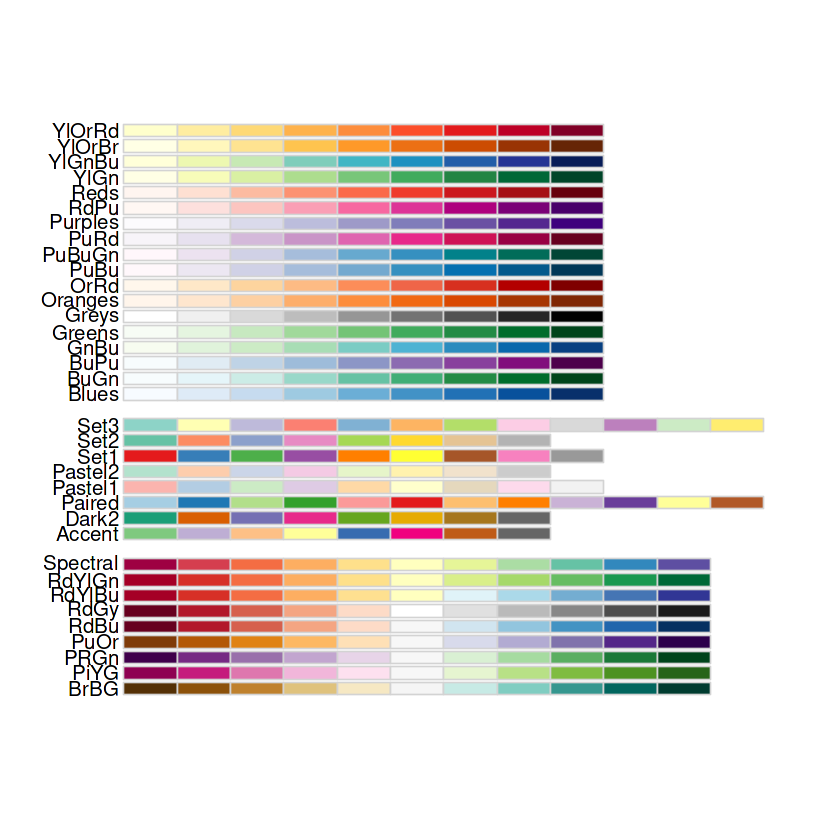

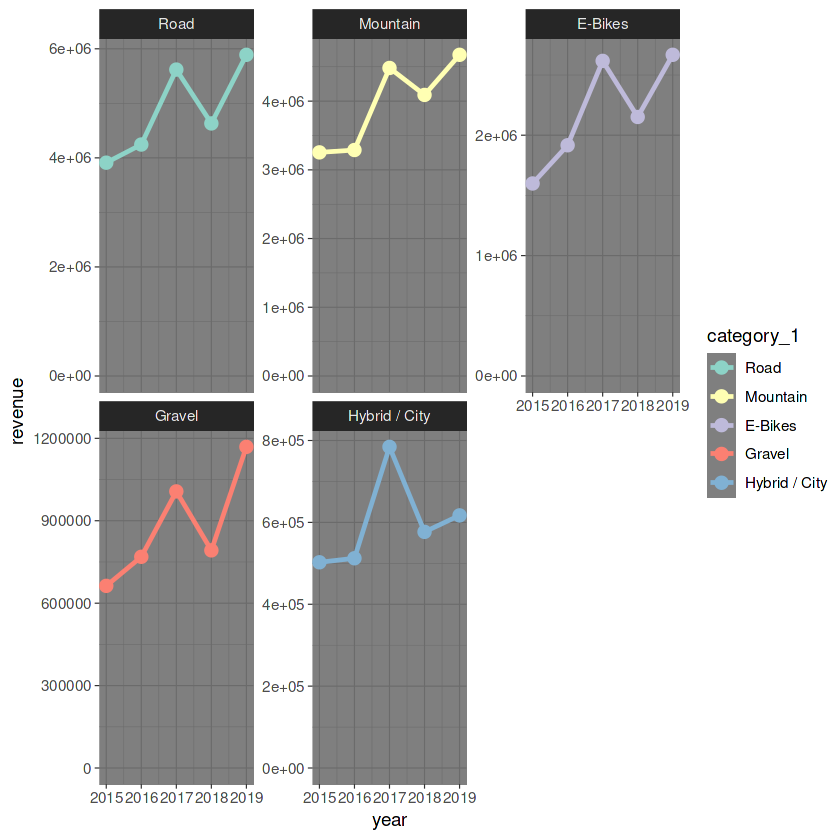

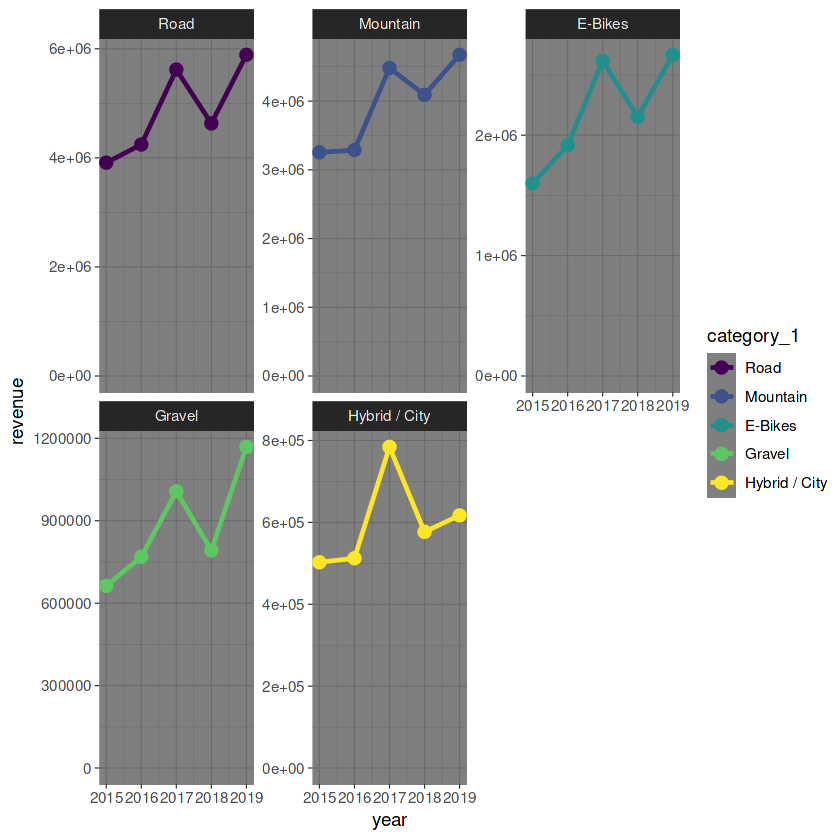

In [140]:
RColorBrewer::display.brewer.all()
RColorBrewer::brewer.pal.info
RColorBrewer::brewer.pal(n = 8, name = "Blues")

g_facet_discrete +
    scale_color_brewer(palette = "Set3") +
    theme_dark()

g_facet_discrete +
    scale_color_viridis_d(option = "D") +
    theme_dark()

* 2.3 Fill by Category 1

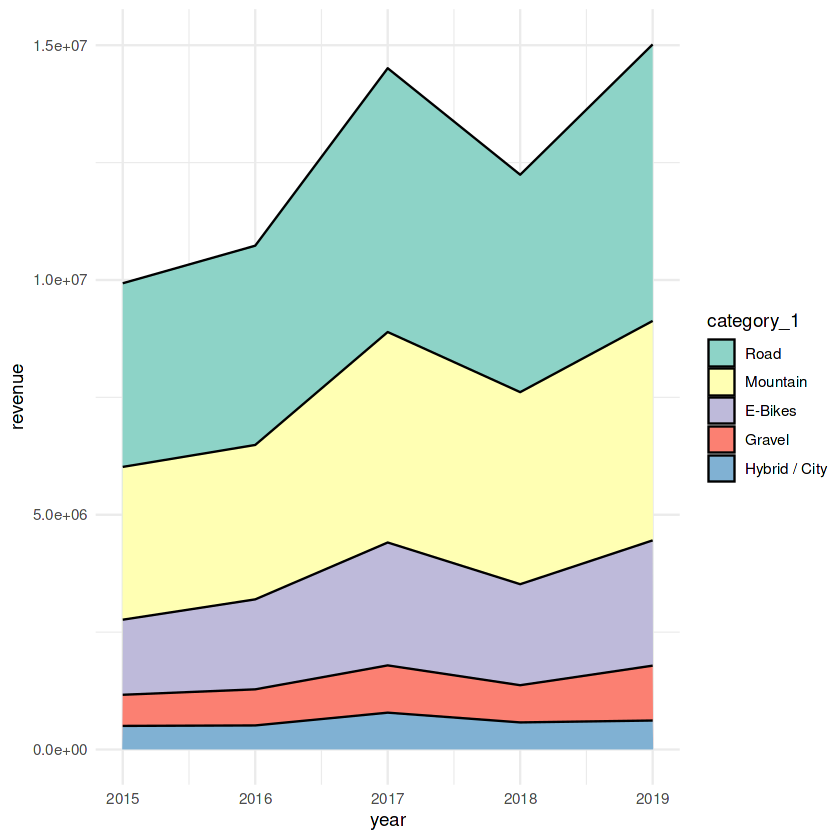

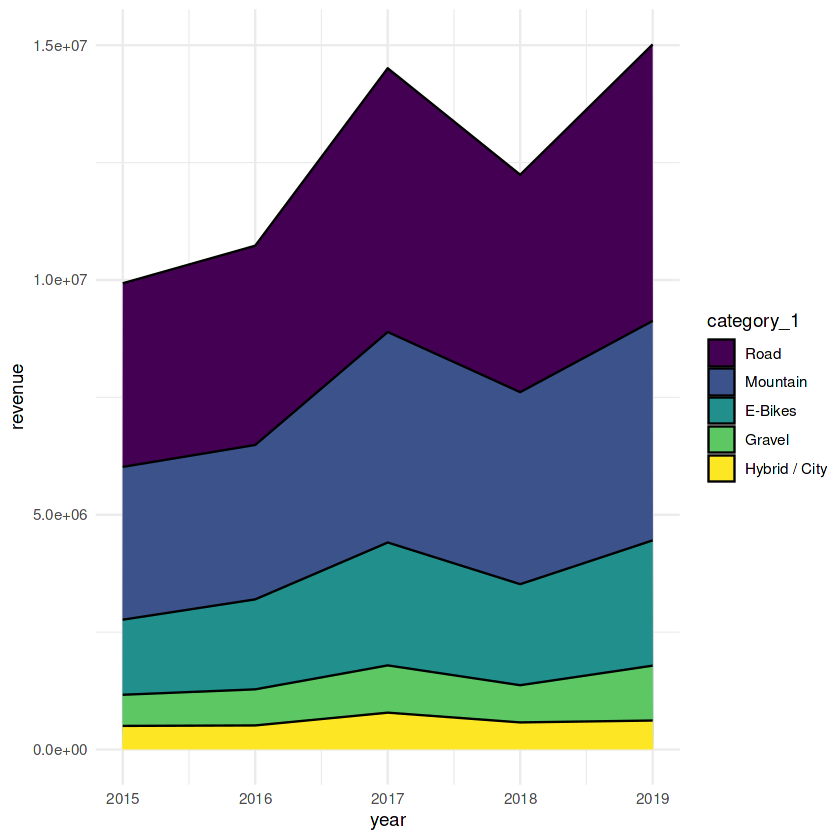

In [141]:
g_area_discrete +
    scale_fill_brewer(palette = "Set3")

g_area_discrete +
    scale_fill_viridis_d()

* 3 Axis Scales

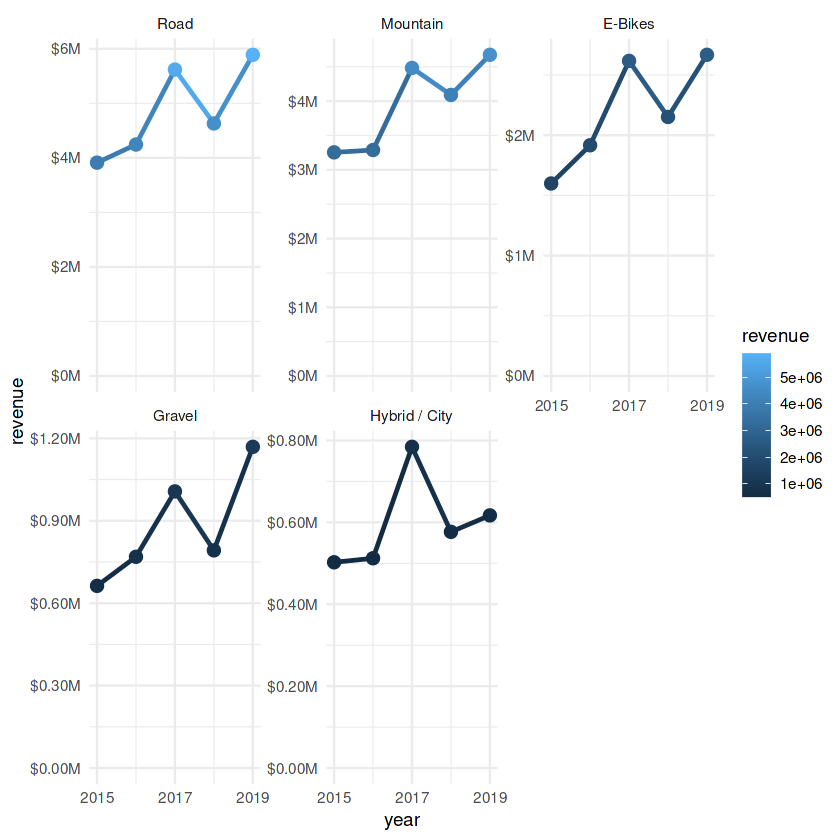

In [142]:
g_facet_continuous +
    scale_x_continuous(breaks = seq(2015, 2019, by = 2)) +
    scale_y_continuous(labels = scales::dollar_format(scale = 1e-6, 
                                                      preix = "",
                                                      suffix = "M"))

# Labels

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”
Warning message:
“The following aesthetics were dropped during statistical transformation:

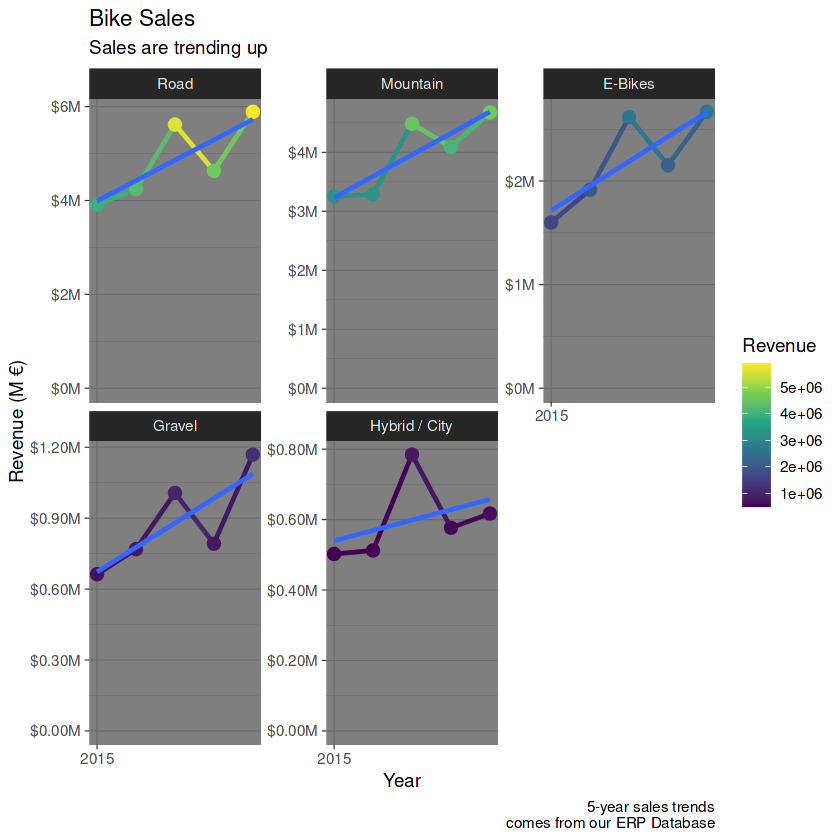

In [143]:
g_facet_continuous +

    scale_x_continuous(breaks = seq(2011, 2015, by = 2)) +
    scale_y_continuous(labels = scales::dollar_format(scale = 1e-6, 
                                                      suffix = "M")) +

    geom_smooth(method = "lm", se = FALSE) +

    scale_color_viridis_c() +
    theme_dark() +

    labs(
        title = "Bike Sales",
        subtitle = "Sales are trending up",
        caption = "5-year sales trends\ncomes from our ERP Database",
        x = "Year",
        y = "Revenue (M €)",
        color = "Revenue" # Legend text
    )


# Themes

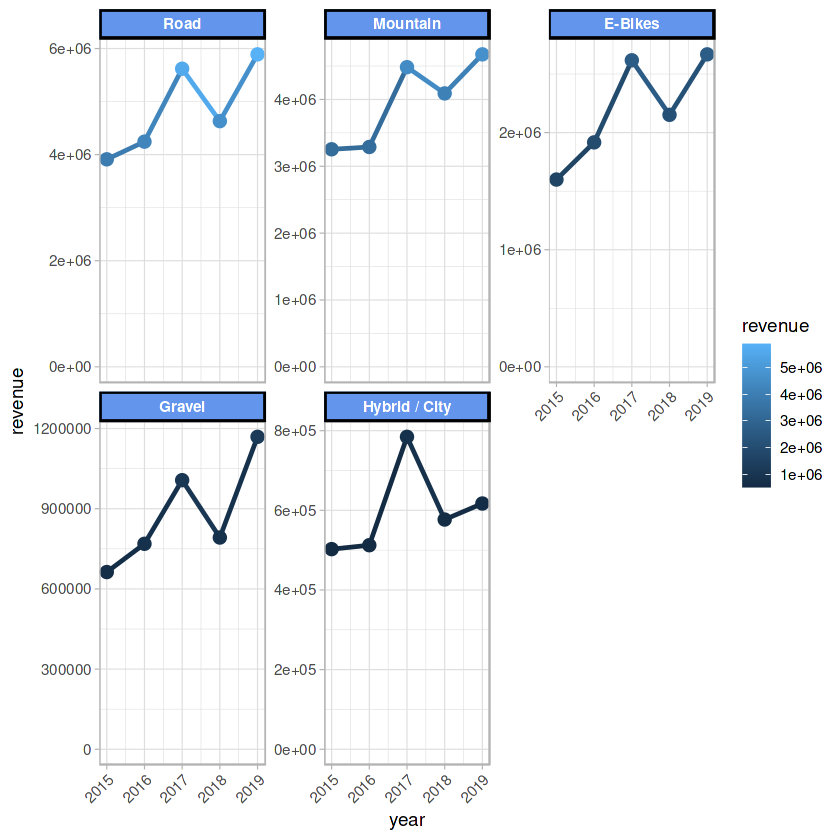

In [144]:
g_facet_continuous +

    theme_light() +

    theme(
        axis.text.x = element_text(
            angle = 45,
            hjust = 1
        ),
        strip.background = element_rect(
            color = "black",
            fill  = "cornflowerblue",
            size  = 1
        ),
        strip.text = element_text(
            face  = "bold",
            color = "white"
        )
    )

# Example of all together

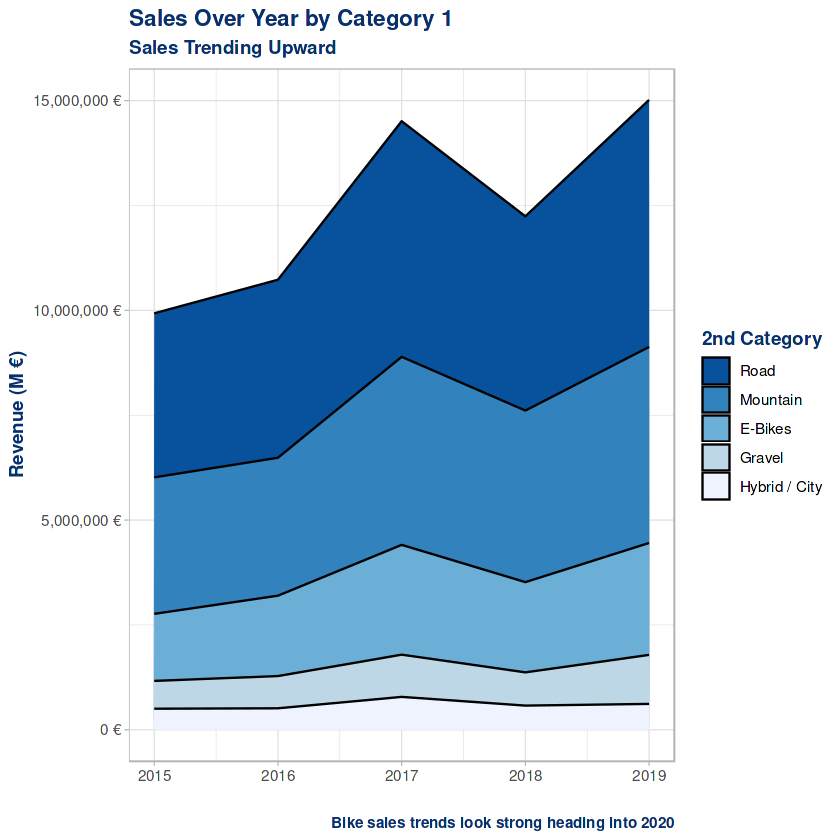

In [145]:
sales_by_year_category_1_tbl %>%

    ggplot(aes(year, revenue, fill = category_1)) +

    geom_area(color = "black") +

    # Scales
    scale_fill_brewer(palette = "Blues", direction = -1) +
    scale_y_continuous(labels = scales::dollar_format(prefix = "", suffix = " €")) +

    # Labels
    labs(
        title = "Sales Over Year by Category 1",
        subtitle = "Sales Trending Upward",
        x = "",
        y = "Revenue (M €)",
        fill = "2nd Category",
        caption = "Bike sales trends look strong heading into 2020"
    ) +

    # Theme
    theme_light() +
    theme(
        title = element_text(face = "bold", color = "#08306B")

    )

# Factors

In [146]:
library(tidyverse)
starwars %>% 
  filter(!is.na(species)) %>%
  count(species, sort = TRUE)

species        n 
1  Human          35
2  Droid           6
3  Gungan          3
4  Kaminoan        2
5  Mirialan        2
6  Twi'lek         2
7  Wookiee         2
8  Zabrak          2
9  Aleena          1
10 Besalisk        1
11 Cerean          1
12 Chagrian        1
13 Clawdite        1
14 Dug             1
15 Ewok            1
16 Geonosian       1
17 Hutt            1
18 Iktotchi        1
19 Kaleesh         1
20 Kel Dor         1
21 Mon Calamari    1
22 Muun            1
23 Nautolan        1
24 Neimodian       1
25 Pau'an          1
26 Quermian        1
27 Rodian          1
28 Skakoan         1
29 Sullustan       1
30 Tholothian      1
31 Togruta         1
32 Toong           1
33 Toydarian       1
34 Trandoshan      1
35 Vulptereen      1
36 Xexto           1
37 Yoda's species  1

In [147]:
starwars %>%
     filter(!is.na(species)) %>%
     mutate(species = as_factor(species) %>% 
                          fct_lump(n = 3)) %>%
     count(species)

species n 
1 Human   35
2 Droid    6
3 Gungan   3
4 Other   39

In [148]:
f <- factor(c("a", "b", "c", "d"), levels = c("b", "c", "d", "a"))
f
fct_reorder(f, c(2,3,1,4))
fct_reorder(f, c(4,3,2,1))

[1] a b c d
Levels: b c d a

[1] a b c d
Levels: c a b d

[1] a b c d
Levels: d c b a

In [149]:
fct_relevel(f, "a")
## a b c d
## Levels: a b c d
fct_relevel(f, "b", "a")
## a b c d
## Levels: b a c d

# Move to the third position
fct_relevel(f, "a", after = 2)
## a b c d
## Levels: b c a d

# Relevel to the end
fct_relevel(f, "a", after = Inf)
## a b c d
## Levels: b c d a
fct_relevel(f, "a", after = 3)
## a b c d
## Levels: b c d a

[1] a b c d
Levels: a b c d

[1] a b c d
Levels: b a c d

[1] a b c d
Levels: b c a d

[1] a b c d
Levels: b c d a

[1] a b c d
Levels: b c d a

# Business Case

## Case 1
* Question: How much purchasing power is in top 5 customers (bikeshops)?
* Goal: Lollipop Chart. Visualize top N customers in terms of Revenue, include cumulative percentage.

**1.0 Load libraries and data import**

In [150]:
# 1.0 Lollipop Chart: Top N Customers ----
library(tidyverse)
library(lubridate)

bike_orderlines_tbl <- read_rds("/kaggle/input/bike-training-dataset/bike_orderlines.rds")

In [151]:
bike_orderlines_tbl %>% glimpse()

Rows: 15,644
Columns: 18
$ order_id       <dbl> 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7…
$ order_line     <dbl> 1, 2, 1, 2, 1, 2, 3, 4, 5, 1, 1, 2, 3, 4, 1, 2, 3, 4, 1…
$ order_date     <dttm> 2015-01-07, 2015-01-07, 2015-01-10, 2015-01-10, 2015-0…
$ model          <chr> "Spectral CF 7 WMN", "Ultimate CF SLX Disc 8.0 ETAP", "…
$ model_year     <dbl> 2021, 2020, 2021, 2019, 2020, 2020, 2020, 2021, 2020, 2…
$ category_1     <chr> "Mountain", "Road", "Mountain", "Road", "Mountain", "Hy…
$ category_2     <chr> "Trail", "Race", "Trail", "Triathlon Bike", "Dirt Jump"…
$ category_3     <chr> "Spectral", "Ultimate", "Neuron", "Speedmax", "Stitched…
$ price          <dbl> 3119, 5359, 2729, 1749, 1219, 1359, 2529, 1559, 3899, 6…
$ quantity       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1…
$ total_price    <dbl> 3119, 5359, 2729, 1749, 1219, 1359, 2529, 1559, 3899, 6…
$ frame_material <chr> "carbon", "carbon", "carbon", "carbon", "aluminium", "c…
$ weight       

In [158]:
tibble(bike_orderlines_tbl)

order_id order_line order_date model                           
1     1         1         2015-01-07 Spectral CF 7 WMN               
2     1         2         2015-01-07 Ultimate CF SLX Disc 8.0 ETAP   
3     2         1         2015-01-10 Neuron CF 8                     
4     2         2         2015-01-10 Speedmax CF 7.0                 
5     3         1         2015-01-10 Stitched 360 Pro                
6     3         2         2015-01-10 Roadlite CF 7.0                 
7     3         3         2015-01-10 Speedmax WMN CF 8.0             
8     3         4         2015-01-10 Inflite 5                       
9     3         5         2015-01-10 Torque CF 8.0                   
10    4         1         2015-01-11 Ultimate CF SLX 9.0 Di2         
11    5         1         2015-01-11 Grand Canyon:ON WMN AL 8.0      
12    5         2         2015-01-11 Ultimate CF SL Disc 8.0 Di2 Aero
13    5         3         2015-01-11 Grail CF SL 8                   
14    5         4         2015-01-11 Torque AL 5.0                   
15    6         1         2015-01-11 Grail CF SL 8 Di2               
16    6         2         2015-01-11 Endurace WMN AL 7.0             
17    6         3         2015-01-11 Commuter:ON 7                   
18    6         4         2015-01-11 Speedmax CF 7.0                 
19    7         1         2015-01-12 Grand Canyon 7 WMN              
20    7         2         2015-01-12 Grail CF SL 8 Di2               
21    7         3         2015-01-12 Ultimate CF SLX Disc 9.0 Di2    
22    7         4         2015-01-12 Neuron:ON WMN 7.0               
23    7         5         2015-01-12 Lux CF SL 6.0                   
24    7         6         2015-01-12 Grail CF SL 7                   
25    7         7         2015-01-12 Lux CF SLX 9.0 Team             
26    7         8         2015-01-12 Pathlite 6 WMN                  
27    7         9         2015-01-12 Speedmax CF SLX 9.0 LTD         
28    7        10         2015-01-12 Endurace WMN CF SL Disc 8.0 Di2 
29    7        11         2015-01-12 Pathlite 6 WMN                  
30    7        12         2015-01-12 Endurace WMN AL 7.0             
⋮     ⋮        ⋮          ⋮          ⋮                               
15615 1995     14         2019-12-23 Neuron:ON 7.0                   
15616 1995     15         2019-12-23 Pathlite:ON 6.0                 
15617 1995     16         2019-12-23 Endurace CF SL Disc 8.0 Pro     
15618 1995     17         2019-12-23 Lux CF SLX 9 LTD                
15619 1995     18         2019-12-23 Torque CF 9.0                   
15620 1995     19         2019-12-23 Pathlite 6 WMN                  
15621 1995     20         2019-12-23 Speedmax WMN CF 8.0             
15622 1995     21         2019-12-23 Grand Canyon Young Hero         
15623 1995     22         2019-12-23 Grail CF SLX 8 eTap             
15624 1995     23         2019-12-23 Speedmax CF SLX 9.0 LTD         
15625 1995     24         2019-12-23 Lux CF SLX 9 Team               
15626 1995     25         2019-12-23 Grand Canyon 6                  
15627 1995     26         2019-12-23 Inflite CF SLX 9                
15628 1995     27         2019-12-23 Endurace CF SL Disc 8.0 Pro     
15629 1995     28         2019-12-23 Endurace WMN AL Disc 6.0        
15630 1995     29         2019-12-23 Grail CF SL 7                   
15631 1996      1         2019-12-23 Spectral WMN CFR 9.0            
15632 1996      2         2019-12-23 Aeroad WMN CF SL 8.0            
15633 1997      1         2019-12-23 Commuter 4.0                    
15634 1998      1         2019-12-23 Roadlite 5                      
15635 1998      2         2019-12-23 Exceed CF 5 WMN                 
15636 1999      1         2019-12-24 Spectral WMN CFR 9.0            
15637 2000      1         2019-12-25 Endurace CF SL Disc 7.0         
15638 2000      2         2019-12-25 Grand Canyon:ON AL 9.0          
15639 2000      3         2019-12-25 Endurace WMN CF SL Disc 8.0     
15640 2000      

**2.0 Data Manipulation**

In [152]:
n <- 10
# Data Manipulation
top_customers_tbl <- bike_orderlines_tbl %>%
    
    # Select relevant columns
    select(bikeshop, total_price) %>%
    
    # Collapse the least frequent values into “other”
    mutate(bikeshop = as_factor(bikeshop) %>% fct_lump(n = n, w = total_price)) %>%
    
    # Group and summarize
    group_by(bikeshop) %>%
    summarize(revenue = sum(total_price)) %>%
    ungroup() %>%
    
    # Reorder the column customer_city by revenue
    mutate(bikeshop = bikeshop %>% fct_reorder(revenue)) %>%
    # Place "Other" at the beginning
    mutate(bikeshop = bikeshop %>% fct_relevel("Other", after = 0)) %>%
    # Sort by this column
    arrange(desc(bikeshop)) %>%
    
    # Add Revenue Text
    mutate(revenue_text = scales::dollar(revenue, 
                                         scale  = 1e-6, 
                                         prefix = "", 
                                         suffix = "M €")) %>%
    
    # Add Cumulative Percent
    mutate(cum_pct = cumsum(revenue) / sum(revenue)) %>%
    mutate(cum_pct_text = scales::percent(cum_pct)) %>%
    
    # Add Rank
    mutate(rank = row_number()) %>%
    mutate(rank = case_when(
        rank == max(rank) ~ NA_integer_,
        TRUE ~ rank
    )) %>%
    
    # Add Label text
    mutate(label_text = str_glue("Rank: {rank}\nRev: {revenue_text}\nCumPct: {cum_pct_text}"))

**3.0 Data Visualization**

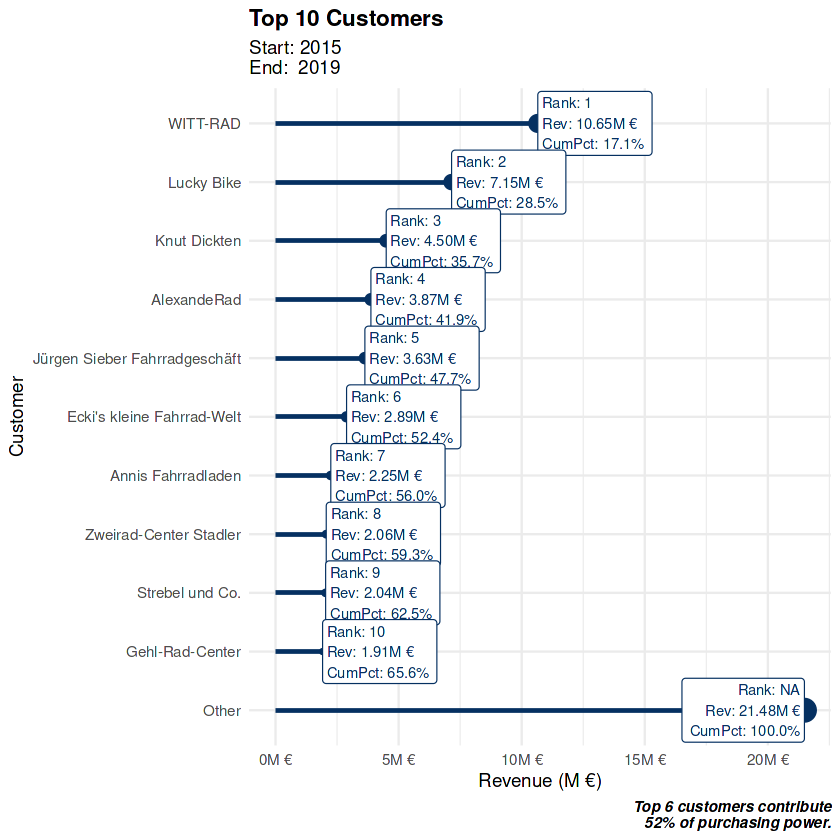

In [153]:
# Data Visualization
top_customers_tbl %>%
    
    # Canvas
    ggplot(aes(revenue, bikeshop)) +
    
    # Geometries
    geom_segment(aes(xend = 0, yend = bikeshop), 
                 color = RColorBrewer::brewer.pal(n = 11, name = "RdBu")[11],
                 size  = 1) +
                 
    geom_point(aes(size = revenue),
               color = RColorBrewer::brewer.pal(n = 11, name = "RdBu")[11]) +
    
    geom_label(aes(label = label_text), 
               hjust = "inward",
               size  = 3,
               color = RColorBrewer::brewer.pal(n = 11, name = "RdBu")[11]) +
    
    # Formatting
    scale_x_continuous(labels = scales::dollar_format(scale = 1e-6, 
                                                      prefix = "",
                                                      suffix = "M €")) +
    labs(
        title = str_glue("Top {n} Customers"),
        subtitle = str_glue(
              "Start: {year(min(bike_orderlines_tbl$order_date))}
               End:  {year(max(bike_orderlines_tbl$order_date))}"),
        x = "Revenue (M €)",
        y = "Customer",
        caption = str_glue("Top 6 customers contribute
                           52% of purchasing power.")
    ) +
    
    theme_minimal() +
    theme(
        legend.position = "none",
        plot.title = element_text(face = "bold"),
        plot.caption = element_text(face = "bold.italic")
    )

## Case 2
* Question: Do specific customers have a purchasing preference?
* Goal: Visualize heatmap of proportion of sales by Secondary Product Category

**1.0 Data Manipulation**

In [154]:
# Select columns and filter categories
pct_sales_by_customer_tbl <- bike_orderlines_tbl %>%
    
    select(bikeshop, category_1, category_2, quantity) %>%
    filter(category_1 %in% c("Mountain","Road")) %>% 
    
    # Group by category and summarize
    group_by(bikeshop, category_1, category_2) %>%
    summarise(total_qty = sum(quantity)) %>%
    ungroup() %>%
    
    # Add missing groups (not necessarily mandatory, but we'd get holes in the plot)
    # complete() creates NAs. We need to set those to 0.
    complete(bikeshop, nesting(category_1, category_2)) %>% 
    mutate(across(total_qty, ~replace_na(., 0))) %>%  
    
    # Group by bikeshop and calculate revenue ratio
    group_by(bikeshop) %>%
    mutate(pct = total_qty / sum(total_qty)) %>%
    ungroup() %>%
    
    # Reverse order of bikeshops
    mutate(bikeshop = as.factor(bikeshop) %>% fct_rev()) %>%
    # Just to verify
    mutate(bikeshop_num = as.numeric(bikeshop))

`summarise()` has grouped output by 'bikeshop', 'category_1'. You can override
using the `.groups` argument.


**2.0 Data Visualization**

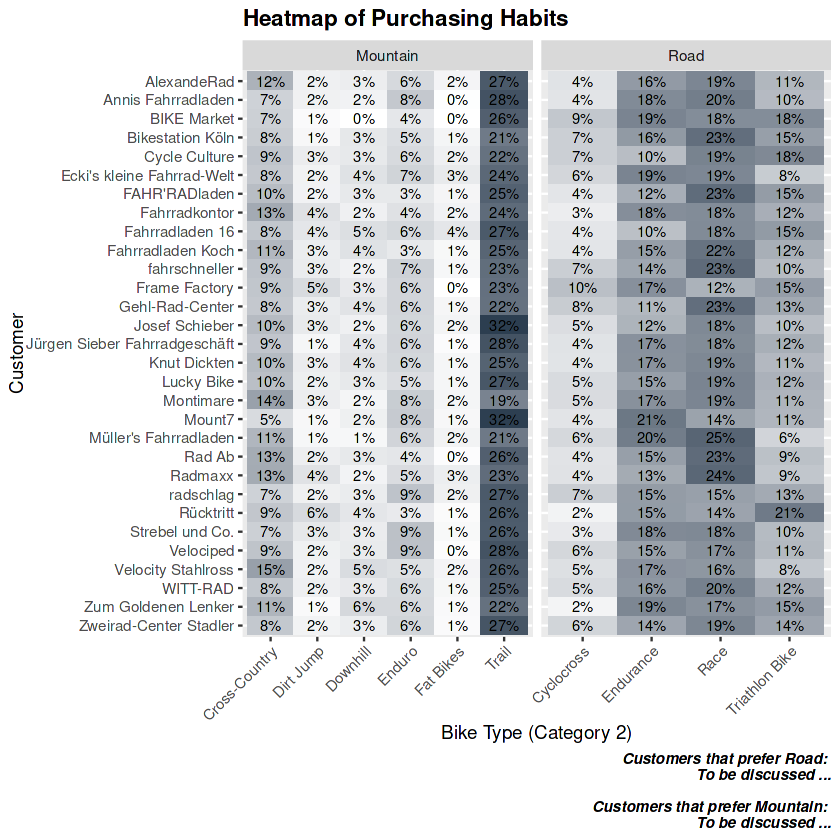

In [155]:
# Data Visualization
  pct_sales_by_customer_tbl %>%
    
    ggplot(aes(category_2, bikeshop)) +
    
    # Geometries
    geom_tile(aes(fill = pct)) +
    geom_text(aes(label = scales::percent(pct, accuracy = 1L)), 
              size = 3) +
    facet_wrap(~ category_1, scales = "free_x") +
    
    # Formatting
    scale_fill_gradient(low = "white", high = "#2C3E50") +
    labs(
      title = "Heatmap of Purchasing Habits",
      x = "Bike Type (Category 2)",
      y = "Customer",
      caption = str_glue(
        "Customers that prefer Road: 
        To be discussed ...
        
        Customers that prefer Mountain: 
        To be discussed ...")
    ) +
    
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "none",
      plot.title = element_text(face = "bold"),
      plot.caption = element_text(face = "bold.italic")
    )

# Challenge
The challenge deals again with covid data. This time we are using a different up to date data set. I recommend to use the tidyverse to wrangle the data, but of course you can also use the data.table library.

In [169]:
library(tidyverse)
covid_data_tbl <- read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

Rows: 311581 Columns: 67
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): iso_code, continent, location, tests_units
dbl  (62): total_cases, new_cases, new_cases_smoothed, total_deaths, new_dea...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [170]:
covid_data_tbl

iso_code continent location    date       total_cases new_cases
1      AFG      Asia      Afghanistan 2020-01-03 NA          0        
2      AFG      Asia      Afghanistan 2020-01-04 NA          0        
3      AFG      Asia      Afghanistan 2020-01-05 NA          0        
4      AFG      Asia      Afghanistan 2020-01-06 NA          0        
5      AFG      Asia      Afghanistan 2020-01-07 NA          0        
6      AFG      Asia      Afghanistan 2020-01-08 NA          0        
7      AFG      Asia      Afghanistan 2020-01-09 NA          0        
8      AFG      Asia      Afghanistan 2020-01-10 NA          0        
9      AFG      Asia      Afghanistan 2020-01-11 NA          0        
10     AFG      Asia      Afghanistan 2020-01-12 NA          0        
11     AFG      Asia      Afghanistan 2020-01-13 NA          0        
12     AFG      Asia      Afghanistan 2020-01-14 NA          0        
13     AFG      Asia      Afghanistan 2020-01-15 NA          0        
14     AFG      Asia      Afghanistan 2020-01-16 NA          0        
15     AFG      Asia      Afghanistan 2020-01-17 NA          0        
16     AFG      Asia      Afghanistan 2020-01-18 NA          0        
17     AFG      Asia      Afghanistan 2020-01-19 NA          0        
18     AFG      Asia      Afghanistan 2020-01-20 NA          0        
19     AFG      Asia      Afghanistan 2020-01-21 NA          0        
20     AFG      Asia      Afghanistan 2020-01-22 NA          0        
21     AFG      Asia      Afghanistan 2020-01-23 NA          0        
22     AFG      Asia      Afghanistan 2020-01-24 NA          0        
23     AFG      Asia      Afghanistan 2020-01-25 NA          0        
24     AFG      Asia      Afghanistan 2020-01-26 NA          0        
25     AFG      Asia      Afghanistan 2020-01-27 NA          0        
26     AFG      Asia      Afghanistan 2020-01-28 NA          0        
27     AFG      Asia      Afghanistan 2020-01-29 NA          0        
28     AFG      Asia      Afghanistan 2020-01-30 NA          0        
29     AFG      Asia      Afghanistan 2020-01-31 NA          0        
30     AFG      Asia      Afghanistan 2020-02-01 NA          0        
⋮      ⋮        ⋮         ⋮           ⋮          ⋮           ⋮        
311552 ZWE      Africa    Zimbabwe    2023-04-18 264613       0       
311553 ZWE      Africa    Zimbabwe    2023-04-19 264619       6       
311554 ZWE      Africa    Zimbabwe    2023-04-20 264623       4       
311555 ZWE      Africa    Zimbabwe    2023-04-21 264630       7       
311556 ZWE      Africa    Zimbabwe    2023-04-22 264632       2       
311557 ZWE      Africa    Zimbabwe    2023-04-23 264637       5       
311558 ZWE      Africa    Zimbabwe    2023-04-24 264639       2       
311559 ZWE      Africa    Zimbabwe    2023-04-25 264643       4       
311560 ZWE      Africa    Zimbabwe    2023-04-26 264644       1       
311561 ZWE      Africa    Zimbabwe    2023-04-27 264647       3       
311562 ZWE      Africa    Zimbabwe    2023-04-28 264663      16       
311563 ZWE      Africa    Zimbabwe    2023-04-29 264679      16       
311564 ZWE      Africa    Zimbabwe    2023-04-30 264683       4       
311565 ZWE      Africa    Zimbabwe    2023-05-01 264685       2       
311566 ZWE      Africa    Zimbabwe    2023-05-02 264685       0       
311567 ZWE      Africa    Zimbabwe    2023-05-03 264698      13       
311568 ZWE      Africa    Zimbabwe    2023-05-04 264708      10       
311569 ZWE      Africa    Zimbabwe    2023-05-05 264719      11       
311570 ZWE      Africa    Zimbabwe    2023-05-06 264749      30       
311571 ZWE      Africa    Zimbabwe    2023-05-07 264766      17       
311572 ZWE      Africa    Zimbabwe    2023-05-08 264776      10       
311573 ZWE      Africa    Zimbabwe    2023-05-09 264782       6       
311574 ZWE      Africa    Zimbabwe    2023-05-10 264791       9       
311575 ZWE      Africa    Zimbabwe    2023-05-11 264799       8       
311576 ZWE      Africa    Zimba

## Challenge 1
* Goal: Map the time course of the cumulative Covid-19 cases! Your plot should look like this:
* Adding the cases for Europe is optional. You can choose your own color theme, but don’t use the default one. Don’t forget to scale the axis properly. The labels can be added with geom_label() or with geom_label_repel() (from the package ggrepel).

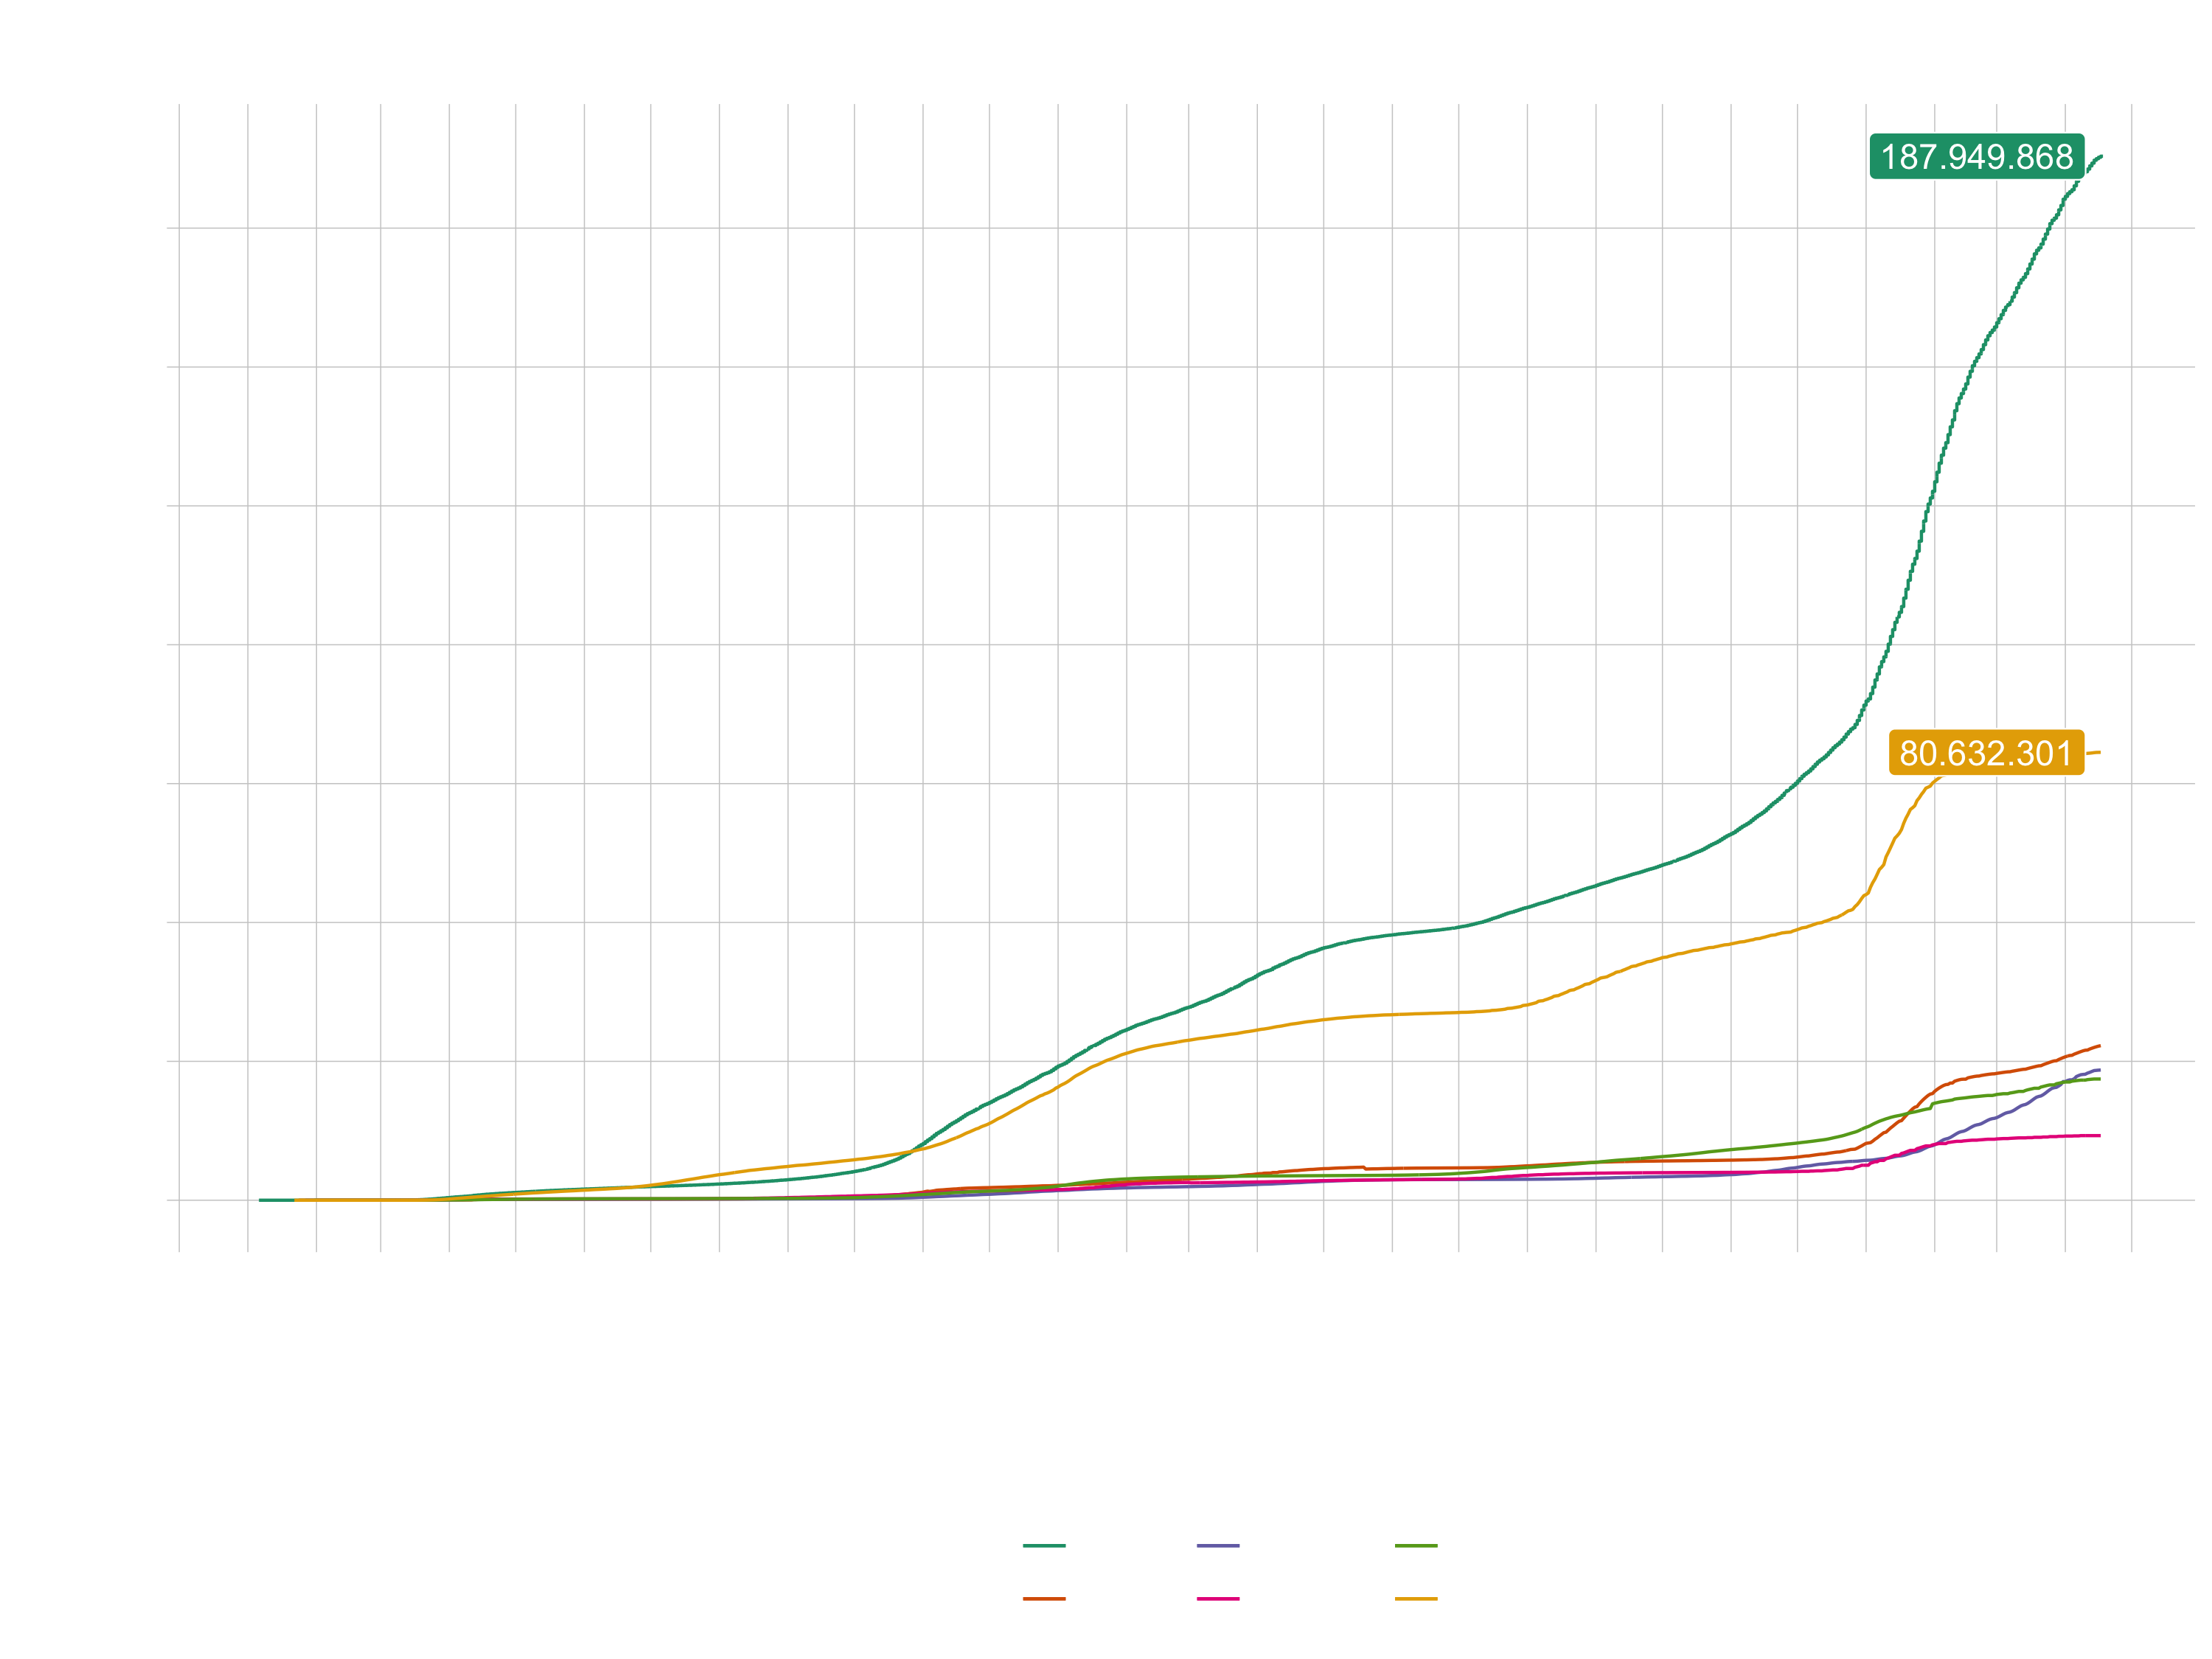

In [171]:
covid_data_tbl %>% glimpse()

Rows: 311,581
Columns: 67
$ iso_code                                   <chr> "AFG", "AFG", "AFG", "AFG",…
$ continent                                  <chr> "Asia", "Asia", "Asia", "As…
$ location                                   <chr> "Afghanistan", "Afghanistan…
$ date                                       <date> 2020-01-03, 2020-01-04, 20…
$ total_cases                                <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_cases                                  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_cases_smoothed                         <dbl> NA, NA, NA, NA, NA, 0, 0, 0…
$ total_deaths                               <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_deaths                                 <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_deaths_smoothed                        <dbl> NA, NA, NA, NA, NA, 0, 0, 0…
$ total_cases_per_million                    <dbl> NA, NA, NA, NA, NA, NA, NA,…
$ new_cases_per_million                      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ new_cases_sm

**Data Manipulation**

In [211]:
covid_data_dt = data.table(covid_data_tbl)
class(covid_data_dt)
covid_data_dt

[1] "data.table" "data.frame"

iso_code continent location    date       total_cases new_cases
1      AFG      Asia      Afghanistan 2020-01-03 NA          0        
2      AFG      Asia      Afghanistan 2020-01-04 NA          0        
3      AFG      Asia      Afghanistan 2020-01-05 NA          0        
4      AFG      Asia      Afghanistan 2020-01-06 NA          0        
5      AFG      Asia      Afghanistan 2020-01-07 NA          0        
6      AFG      Asia      Afghanistan 2020-01-08 NA          0        
7      AFG      Asia      Afghanistan 2020-01-09 NA          0        
8      AFG      Asia      Afghanistan 2020-01-10 NA          0        
9      AFG      Asia      Afghanistan 2020-01-11 NA          0        
10     AFG      Asia      Afghanistan 2020-01-12 NA          0        
11     AFG      Asia      Afghanistan 2020-01-13 NA          0        
12     AFG      Asia      Afghanistan 2020-01-14 NA          0        
13     AFG      Asia      Afghanistan 2020-01-15 NA          0        
14     AFG      Asia      Afghanistan 2020-01-16 NA          0        
15     AFG      Asia      Afghanistan 2020-01-17 NA          0        
16     AFG      Asia      Afghanistan 2020-01-18 NA          0        
17     AFG      Asia      Afghanistan 2020-01-19 NA          0        
18     AFG      Asia      Afghanistan 2020-01-20 NA          0        
19     AFG      Asia      Afghanistan 2020-01-21 NA          0        
20     AFG      Asia      Afghanistan 2020-01-22 NA          0        
21     AFG      Asia      Afghanistan 2020-01-23 NA          0        
22     AFG      Asia      Afghanistan 2020-01-24 NA          0        
23     AFG      Asia      Afghanistan 2020-01-25 NA          0        
24     AFG      Asia      Afghanistan 2020-01-26 NA          0        
25     AFG      Asia      Afghanistan 2020-01-27 NA          0        
26     AFG      Asia      Afghanistan 2020-01-28 NA          0        
27     AFG      Asia      Afghanistan 2020-01-29 NA          0        
28     AFG      Asia      Afghanistan 2020-01-30 NA          0        
29     AFG      Asia      Afghanistan 2020-01-31 NA          0        
30     AFG      Asia      Afghanistan 2020-02-01 NA          0        
⋮      ⋮        ⋮         ⋮           ⋮          ⋮           ⋮        
311552 ZWE      Africa    Zimbabwe    2023-04-18 264613       0       
311553 ZWE      Africa    Zimbabwe    2023-04-19 264619       6       
311554 ZWE      Africa    Zimbabwe    2023-04-20 264623       4       
311555 ZWE      Africa    Zimbabwe    2023-04-21 264630       7       
311556 ZWE      Africa    Zimbabwe    2023-04-22 264632       2       
311557 ZWE      Africa    Zimbabwe    2023-04-23 264637       5       
311558 ZWE      Africa    Zimbabwe    2023-04-24 264639       2       
311559 ZWE      Africa    Zimbabwe    2023-04-25 264643       4       
311560 ZWE      Africa    Zimbabwe    2023-04-26 264644       1       
311561 ZWE      Africa    Zimbabwe    2023-04-27 264647       3       
311562 ZWE      Africa    Zimbabwe    2023-04-28 264663      16       
311563 ZWE      Africa    Zimbabwe    2023-04-29 264679      16       
311564 ZWE      Africa    Zimbabwe    2023-04-30 264683       4       
311565 ZWE      Africa    Zimbabwe    2023-05-01 264685       2       
311566 ZWE      Africa    Zimbabwe    2023-05-02 264685       0       
311567 ZWE      Africa    Zimbabwe    2023-05-03 264698      13       
311568 ZWE      Africa    Zimbabwe    2023-05-04 264708      10       
311569 ZWE      Africa    Zimbabwe    2023-05-05 264719      11       
311570 ZWE      Africa    Zimbabwe    2023-05-06 264749      30       
311571 ZWE      Africa    Zimbabwe    2023-05-07 264766      17       
311572 ZWE      Africa    Zimbabwe    2023-05-08 264776      10       
311573 ZWE      Africa    Zimbabwe    2023-05-09 264782       6       
311574 ZWE      Africa    Zimbabwe    2023-05-10 264791       9       
311575 ZWE      Africa    Zimbabwe    2023-05-11 264799       8       
311576 ZWE      Africa    Zimba

* convert date to dt Date

In [212]:
covid_data_dt[, date := as.Date(date)]

* extract year and month

In [213]:
covid_data_dt[, year_month := format(date, "%Y-%m")]

* see result, and calculate total new cases for each month

In [223]:
covid_data_new_cases_per_month_dt = covid_data_dt[!is.na(new_cases), .(new_cases_per_month = sum(new_cases)), by = .(year_month, location)]
covid_data_new_cases_per_month_dt

year_month location    new_cases_per_month
1     2020-01    Afghanistan     0              
2     2020-02    Afghanistan     1              
3     2020-03    Afghanistan   113              
4     2020-04    Afghanistan  1713              
5     2020-05    Afghanistan 12616              
6     2020-06    Afghanistan 16795              
7     2020-07    Afghanistan  5304              
8     2020-08    Afghanistan  1601              
9     2020-09    Afghanistan  1111              
10    2020-10    Afghanistan  2080              
11    2020-11    Afghanistan  4881              
12    2020-12    Afghanistan  6115              
13    2021-01    Afghanistan  2693              
14    2021-02    Afghanistan   691              
15    2021-03    Afghanistan   740              
16    2021-04    Afghanistan  3291              
17    2021-05    Afghanistan 12093              
18    2021-06    Afghanistan 46821              
19    2021-07    Afghanistan 28495              
20    2021-08    Afghanistan  6066              
21    2021-09    Afghanistan  1832              
22    2021-10    Afghanistan  1036              
23    2021-11    Afghanistan  1172              
24    2021-12    Afghanistan   799              
25    2022-01    Afghanistan  4081              
26    2022-02    Afghanistan 11255              
27    2022-03    Afghanistan  4299              
28    2022-04    Afghanistan  1179              
29    2022-05    Afghanistan  1390              
30    2022-06    Afghanistan  2167              
⋮     ⋮          ⋮           ⋮                  
10057 2020-12    Zimbabwe     3675              
10058 2021-01    Zimbabwe    19646              
10059 2021-02    Zimbabwe     2787              
10060 2021-03    Zimbabwe      800              
10061 2021-04    Zimbabwe     1377              
10062 2021-05    Zimbabwe      709              
10063 2021-06    Zimbabwe     9589              
10064 2021-07    Zimbabwe    58957              
10065 2021-08    Zimbabwe    17091              
10066 2021-09    Zimbabwe     5904              
10067 2021-10    Zimbabwe     2469              
10068 2021-11    Zimbabwe     1272              
10069 2021-12    Zimbabwe    77502              
10070 2022-01    Zimbabwe    17732              
10071 2022-02    Zimbabwe     6515              
10072 2022-03    Zimbabwe    10207              
10073 2022-04    Zimbabwe     1660              
10074 2022-05    Zimbabwe     4556              
10075 2022-06    Zimbabwe     3188              
10076 2022-07    Zimbabwe      792              
10077 2022-08    Zimbabwe      348              
10078 2022-09    Zimbabwe      739              
10079 2022-10    Zimbabwe      704              
10080 2022-11    Zimbabwe     1049              
10081 2022-12    Zimbabwe      882              
10082 2023-01    Zimbabwe     2334              
10083 2023-02    Zimbabwe     1715              
10084 2023-03    Zimbabwe      393              
10085 2023-04    Zimbabwe      141              
10086 2023-05    Zimbabwe      165

* filter locations

In [242]:
chosen_locations = c("Germany", "United Kingdom", "France", "Spain", "United States")

covid_data_new_cases_per_month_per_chosen_locations_dt = covid_data_new_cases_per_month_dt[location %in% chosen_locations]

covid_data_new_cases_per_month_per_chosen_locations_dt 
covid_data_new_cases_per_month_per_chosen_locations_dt %>% glimpse()

year_month location      new_cases_per_month
1   2020-01    France              6            
2   2020-02    France             51            
3   2020-03    France          43920            
4   2020-04    France          83089            
5   2020-05    France          21170            
6   2020-06    France          11138            
7   2020-07    France          20620            
8   2020-08    France         111684            
9   2020-09    France         295067            
10  2020-10    France         925313            
11  2020-11    France         673758            
12  2020-12    France         379156            
13  2021-01    France         549570            
14  2021-02    France         480930            
15  2021-03    France         836770            
16  2021-04    France         770378            
17  2021-05    France         363594            
18  2021-06    France          95959            
19  2021-07    France         309323            
20  2021-08    France         583962            
21  2021-09    France         238638            
22  2021-10    France         143146            
23  2021-11    France         456897            
24  2021-12    France        2088443            
25  2022-01    France        9069358            
26  2022-02    France        3477408            
27  2022-03    France        2667625            
28  2022-04    France        3073891            
29  2022-05    France         832085            
30  2022-06    France        1422860            
⋮   ⋮          ⋮             ⋮                  
176 2020-12    United States  6170028           
177 2021-01    United States  6285448           
178 2021-02    United States  2467058           
179 2021-03    United States  1776581           
180 2021-04    United States  1832202           
181 2021-05    United States   981676           
182 2021-06    United States   385721           
183 2021-07    United States  1373312           
184 2021-08    United States  4114589           
185 2021-09    United States  4185050           
186 2021-10    United States  2660463           
187 2021-11    United States  2444998           
188 2021-12    United States  5449603           
189 2022-01    United States 20444764           
190 2022-02    United States  4380740           
191 2022-03    United States  1022157           
192 2022-04    United States  1163440           
193 2022-05    United States  2698000           
194 2022-06    United States  3066561           
195 2022-07    United States  3922935           
196 2022-08    United States  2879420           
197 2022-09    United States  1858371           
198 2022-10    United States  1204618           
199 2022-11    United States  1125356           
200 2022-12    United States  2111048           
201 2023-01    United States  1522698           
202 2023-02    United States  1085170           
203 2023-03    United States   678002           
204 2023-04    United States   568838           
205 2023-05    United States   170425

Rows: 205
Columns: 3
$ year_month          <chr> "2020-01", "2020-02", "2020-03", "2020-04", "2020-…
$ location            <chr> "France", "France", "France", "France", "France", …
$ new_cases_per_month <dbl> 6, 51, 43920, 83089, 21170, 11138, 20620, 111684, …


* calculate cumulative

In [243]:
#covid_data_new_cases_per_month_per_chosen_locations_dt[, year_month := as.Date(year_month, format = "%Y-%m")]
covid_data_new_cases_per_month_per_chosen_locations_dt[, year_month := as.character(year_month)]
covid_data_new_cases_per_month_per_chosen_locations_dt[, cumulative_cases := cumsum(new_cases_per_month), by = .(location)]

* get the final cumulative number

In [290]:
last_value = covid_data_new_cases_per_month_per_chosen_locations_dt %>%
  group_by(location) %>%
  filter(year_month == max(year_month)) %>%
  ungroup()

* plot line graph

In [301]:
ggplot(covid_data_new_cases_per_month_per_chosen_locations_dt, aes(x = year_month, y = cumulative_cases, color = location, group = location)) +
  geom_line() +

#geom_text(data = last_value, aes(label = cumulative_cases), hjust = 1, vjust = 1, color = "blue")+
geom_label_repel(data = last_value, aes(label = cumulative_cases), show.legend = TRUE, nudge_x = 0.01, nudge_y = 5000000, direction = "y") +
theme_dark() +
#theme_minimal() +
  #scale_x_date(date_labels = "%Y-%m", date_breaks = "1 month") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
        plot.title = element_text(face = "bold", color = "black"),
        plot.caption = element_text(face = "bold.italic", color = "black"),
        legend.position = "bottom",
     legend.text = element_text(color = "black"),
     legend.title = element_text(color = "black")) +
#theme_minimal() +

  labs(
    title = "Covid 19 confirm cases worldwdie",
    subtitle = "As of 19.04.2022",
    x = "Date",
    y = "Cumulative Cases",
    color = "Country"
      #show.legend = TRUE
  ) +
    scale_y_continuous(labels = function(x) paste0(x / 500000, "M")) 
                    

## Challenge 2
* Goal: Visualize the distribution of the mortality rate (deaths / population) with geom_map() (alternatively, you can plot the case-fatality rate (deaths / cases)). The necessary longitudinal and lateral data can be accessed with this function:

In [303]:
world <- map_data("world")

In [304]:
world

long      lat      group order  region      subregion     
1      -69.89912 12.45200 1      1     Aruba       NA            
2      -69.89571 12.42300 1      2     Aruba       NA            
3      -69.94219 12.43853 1      3     Aruba       NA            
4      -70.00415 12.50049 1      4     Aruba       NA            
5      -70.06612 12.54697 1      5     Aruba       NA            
6      -70.05088 12.59707 1      6     Aruba       NA            
7      -70.03511 12.61411 1      7     Aruba       NA            
8      -69.97314 12.56763 1      8     Aruba       NA            
9      -69.91181 12.48047 1      9     Aruba       NA            
10     -69.89912 12.45200 1     10     Aruba       NA            
12      74.89131 37.23164 2     12     Afghanistan NA            
13      74.84023 37.22505 2     13     Afghanistan NA            
14      74.76738 37.24917 2     14     Afghanistan NA            
15      74.73896 37.28564 2     15     Afghanistan NA            
16      74.72666 37.29072 2     16     Afghanistan NA            
17      74.66895 37.26670 2     17     Afghanistan NA            
18      74.55899 37.23662 2     18     Afghanistan NA            
19      74.37217 37.15771 2     19     Afghanistan NA            
20      74.37617 37.13735 2     20     Afghanistan NA            
21      74.49796 37.05722 2     21     Afghanistan NA            
22      74.52646 37.03066 2     22     Afghanistan NA            
23      74.54140 37.02217 2     23     Afghanistan NA            
24      74.43106 36.98369 2     24     Afghanistan NA            
25      74.19473 36.89688 2     25     Afghanistan NA            
26      74.03887 36.82573 2     26     Afghanistan NA            
27      74.00185 36.82310 2     27     Afghanistan NA            
28      73.90781 36.85293 2     28     Afghanistan NA            
29      73.76914 36.88848 2     29     Afghanistan NA            
30      73.73183 36.88779 2     30     Afghanistan NA            
31      73.41113 36.88169 2     31     Afghanistan NA            
⋮      ⋮         ⋮        ⋮     ⋮      ⋮           ⋮             
100933  5.062304 52.43071 1625  100933 Netherlands IJsselmeer    
100934  5.036230 52.40459 1625  100934 Netherlands IJsselmeer    
100935  5.014062 52.36431 1625  100935 Netherlands IJsselmeer    
100936  5.039941 52.34414 1625  100936 Netherlands IJsselmeer    
100937  5.316016 52.29150 1625  100937 Netherlands IJsselmeer    
100938  5.495313 52.25190 1625  100938 Netherlands IJsselmeer    
100939  5.795117 52.42768 1625  100939 Netherlands IJsselmeer    
100941  5.499121 52.30186 1626  100941 Netherlands Zuid-Flevoland
100942  5.424414 52.29766 1626  100942 Netherlands Zuid-Flevoland
100943  5.242383 52.33374 1626  100943 Netherlands Zuid-Flevoland
100944  5.183887 52.35835 1626  100944 Netherlands Zuid-Flevoland
100945  5.168555 52.37876 1626  100945 Netherlands Zuid-Flevoland
100946  5.376953 52.49033 1626  100946 Netherlands Zuid-Flevoland
100947  5.539258 52.55772 1626  100947 Netherlands Zuid-Flevoland
100948  5.658106 52.58760 1626  100948 Netherlands Zuid-Flevoland
100949  5.735547 52.58223 1626  100949 Netherlands Zuid-Flevoland
100950  5.797461 52.56460 1626  100950 Netherlands Zuid-Flevoland
100951  5.829492 52.53545 1626  100951 Netherlands Zuid-Flevoland
100952  5.834179 52.50225 1626  100952 Netherlands Zuid-Flevoland
100953  5.800879 52.46577 1626  100953 Netherlands Zuid-Flevoland
100954  5.741016 52.42900 1626  100954 Netherlands Zuid-Flevoland
100955  5.620605 52.37593 1626  100955 Netherlands Zuid-Flevoland
100956  5.548047 52.32441 1626  100956 Netherlands Zuid-Flevoland
100957  5.499121 52.30186 1626  100957 Netherlands Zuid-Flevoland
100959 12.439160 41.89839 1627  100959 Vatican     enclave       
100960 12.438379 41.90620 1627  100960 Vatican     enclave       
100961 12.430566 41.90547 1627  100961 Vatican     enclave       
100962 12.427539 41.90073 1627  100962 Vatican     enclave       
100963 12.430566 41.89756 1627  100963 Vatican 